In [2]:
# Import the necessary libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import ast

from wordcloud import WordCloud

matplotlib.style.use('ggplot')

%matplotlib inline

In [3]:
# Maximum number of columns to be printed
pd.options.display.max_columns = 500
# Maximum number of rows to be printed
pd.options.display.max_rows = 500
# Maximum width of a column while displaying
pd.options.display.max_colwidth = 40

##### Let's take a look into the raw CSV file to understand the physical format in which data is present in it

In [4]:
# Let's take a look of the top of the file
! head -2 crunchbase.csv

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
0,Aujas Networks,2008,11 - 50,"Aujas Networks Pvt. Ltd. offers information technology digital security solutions and services for enabling digital defense to clients. The company offers services in the areas of security vulnerability, security content management, and identity and access management. Its consulting services include preventive consulting, such as strategy consulting, enterprise risk, management, technology, consulting, and DR/BCP consulting; reactive consulting, including security postures, security audit, and recovery strategy; and detective consulting, such as incident response solutions. The companyâ€™s preventive implementation solutions comprise SCM/SAMIIAM, secure products, and compliance solutions. Its detective implementation solutions include application code review solutions. The companyâ€™s management solutions comprise preventive management, including enterprise risk, 

In [5]:
# Let's take a look of the bottom of the file
! tail -2 crunchbase.csv

We bring to market very high quality products that are reliable and extremely simple to use.
","Bangalore, Karnataka","Medical Device, Health Care, Medical","[['Jan, 2016', 'undisclosed amount / Series B', '—', '—', '2']]","[['Cipher Plexus', 'Series B', '-'], ['domestic HNIs', 'Series B', '-']]"


#### Taking a look of the head and tail of the file helps to understand if I need to skip any lines at the beginning or at the end while loading data into DataFrame using pandas libraies

In [6]:
# Create a dataframe using a csv file. 
#
# Since the file is not too big, set low_memory=False. That will
# tell pandas to automatically detect the datatype of each column.
#
# Seperator should be comma as seen in the csv file
df_raw = pd.read_csv('crunchbase.csv', sep=",", low_memory=False)

In [7]:
# Check the datatypes of different columns
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 9 columns):
Unnamed: 0        464 non-null int64
name              464 non-null object
founded_date      464 non-null object
employee_count    464 non-null object
description       456 non-null object
location          452 non-null object
categories        457 non-null object
funding_data      412 non-null object
investor_data     403 non-null object
dtypes: int64(1), object(8)
memory usage: 32.7+ KB


In [8]:
# Take a look of first few rows of the data
df_raw.head(2)

,Unnamed: 0,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
0,0,Aujas Networks,2008,11 - 50,Aujas Networks Pvt. Ltd. offers info...,"Bangalore, Karnataka","Security, Cloud Security, Informatio...","[['Nov, 2013', '$5.4M / Series B', '...","[['IDG Ventures India', 'Series A', ..."
1,0,CanvasFilp,"August 1, 2014",11 - 50,CanvasFlip is fastest growing protot...,"Bangalore, Karnataka",Software,"[['Sep, 2015', '$1.2M / Seed', '—', ...","[['Bessemer Venture Partners', 'Seed..."


#### Although I am printing just 2 lines here, I have actually looked into 20 to 50 lines to understand if there is any visible issues with the data or not. Few observations:
- There are 9 columns describing each startup
- There is an "Unnamed: 0" Column at the begining with values as 0. It can be possibly removed.
- One startup may be associated with multiple categories.
- The founded_date column has some extra text appended which needs to be cleaned up.
- funding_data and investor_data looks like list of lists. Data needs to be extracted from there.

In [9]:
# Check the shape of the dataframe
df_raw.shape

(464, 9)

#### There are 464 rows and 9 columns.

#### There is an Unnamed Column at the begining. That may be just because there is a comma to start with. I am going to check if all the rows for that column has value 0 or not. If yes, remove the column.

In [10]:
# Check if all the elements of the column has value 0 only
df_raw['Unnamed: 0'].sum()

0

#### The Unnamed column consists of 0 values only. It's safe to remove the column.

In [11]:
# Drop the Unnamed column
df_raw.drop(df_raw.columns[0], axis=1, inplace=True)

In [12]:
# Check the column names
df_raw.columns

Index(['name', 'founded_date', 'employee_count', 'description', 'location',
       'categories', 'funding_data', 'investor_data'],
      dtype='object')

#### At this point, for each startup, we have following information: 
- Name
- Date on which it is founded date 
- Number of employees 
- Decsription 
- Geographical location of the startup
- Categories to which the start up can be tagged with 
- Funding data 
- Investor data

## 1. Check for duplicate rows

In [15]:
# Check for duplicate rows
#
# Sort the resulting dataframe based on name for easy inspection
#
# Take a look of the duplicates as well as orginals
df_raw[df_raw.duplicated(keep=False)].sort_values(by='name').head()

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
62,99Games Online Private Limited,2008,11 - 50,Putting casual games right in your p...,"Udupi, Karnataka","Android, Developer Platform, Video G...","[['Jan, 2017', 'undisclosed amount /...","[['Ascent Capital', 'Series B\xa0(Le..."
237,99Games Online Private Limited,2008,11 - 50,Putting casual games right in your p...,"Udupi, Karnataka","Android, Developer Platform, Video G...","[['Jan, 2017', 'undisclosed amount /...","[['Ascent Capital', 'Series B\xa0(Le..."
293,BHIVE WORKSPACE,"October 15, 2014",11 - 50,BHIVE Workspace prides in being the ...,Bangalore,"Collaboration, Coworking, Real Estate","[['Jun, 2017', '$1.2M / Seed', '—', ...","[['Arihant Patni', 'Angel', '-'], ['..."
292,BHIVE WORKSPACE,"October 15, 2014",11 - 50,BHIVE Workspace prides in being the ...,Bangalore,"Collaboration, Coworking, Real Estate","[['Jun, 2017', '$1.2M / Seed', '—', ...","[['Arihant Patni', 'Angel', '-'], ['..."
59,Embibe,2012,11 - 50,Embibe provides educational services...,Mumbai,"Education, Tutoring","[['May, 2014', '$4M / Venture', '—',...","[['Kalaari Capital', 'Venture', '-']..."


#### Visual inspection confirms that duplicate rows are matching with each other on the basis of all the features/columns. Hence it's safe to drop the duplicates.

In [16]:
# How many duplicates are there?
df_raw[df_raw.duplicated()].sort_values(by='name').shape[0]

9

In [17]:
# Keep the first row and drop the rest of duplicate rows 
df_raw.drop_duplicates(keep='first', inplace=True)

# Multiple rows have been removed. Hence, reset the index of the dataframe
df_raw.reset_index(drop=True, inplace=True)

## 2. Check for missing values

In [18]:
# Check for missing values
df_raw.isnull().sum()

name               0
founded_date       0
employee_count     0
description        8
location          12
categories         7
funding_data      52
investor_data     61
dtype: int64

#### There are missing values for description, location, categories, funding_data and investor_data

#### Let's check the rows for which description, location, categories, funding_data and investor_data are null. If there is any such row, we can drop that row.

In [19]:
df_raw[df_raw.funding_data.isnull() 
       & df_raw.investor_data.isnull() 
       & df_raw.location.isnull() 
       & df_raw.description.isnull()
       & df_raw.categories.isnull()]

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
88,LeanTrack: Community for Student Sta...,Unknown,11 - 50,NaN,NaN,NaN,NaN,NaN


#### There is one such row, it can be safely dropped

In [20]:
df_raw = df_raw[~(df_raw.funding_data.isnull() 
       & df_raw.investor_data.isnull() 
       & df_raw.location.isnull() 
       & df_raw.description.isnull()
       & df_raw.categories.isnull())]

In [21]:
# Let's check the rows for which location, categories, funding_data and investor_data are null.
# If there is any we can drop that row.
df_raw[df_raw.funding_data.isnull() 
       & df_raw.investor_data.isnull() 
       & df_raw.location.isnull() 
       & df_raw.categories.isnull()]

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
53,Recipe Book,"June 1, 2015Aliases:Recipe Book# of",11 - 50,Recipe Book is the popular intellige...,NaN,NaN,NaN,NaN


#### There is one such row, we may drop that as well as it is not carrying any valuable information.

In [22]:
df_raw = df_raw[~(df_raw.funding_data.isnull() 
           & df_raw.investor_data.isnull() 
           & df_raw.location.isnull() 
           & df_raw.categories.isnull())]

In [23]:
# Check for the startups for which categories is unknown
df_raw[df_raw.categories.isnull()]

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data
2,Canvazify,"January 13, 2014",11 - 50,NaN,"Pune, Maharashtra",NaN,NaN,NaN
270,Wowflux Labs,2015,11 - 50,Wowflux Labs is a manufacture profes...,"New Delhi, Delhi",NaN,"[['May, 2017', 'undisclosed amount /...",NaN
286,"Hullo, Inc.","November, 2015",11 - 50,"Hullo offers TinCan, an application ...","San Francisco, California",NaN,"[['Dec, 2015', 'undisclosed amount /...","[['Arihant Patni', 'Convertible Note..."
325,Applancer.co,"December 16, 2016",11 - 50,What does it do?\nApplancer is a app...,"Chandigarh, Chandigarh",NaN,"[['Dec, 2016', '$50k / Seed', '—', '...","[['Sahil Kohli', 'Seed', '-']]"
400,RankJunction,Unknown,11 - 50,NaN,"Nagpur, Maharashtra",NaN,"[['Jan, 2014', '$185.29k / Angel', '...","[['Artha India Ventures', 'Angel', '..."


#### Check for the startups for which funding data is unknown.
A quick look at the crunchbase website shows that missing funding information does not mean that the startup never received funding. For example, DronaHQ received funding, but in our dataset DronaHQ does not have funding information.

In [28]:
#Check for the startups for which funding data is unknown.
df_raw[df_raw.funding_data.isnull()].shape[0]

50

In [29]:
# Startups for which funding as well as investor data is missing
df_raw[df_raw.funding_data.isnull() & df_raw.investor_data.isnull()].shape[0]

50

In [30]:
# Startups for which funding data is there but investor data is missing
#
# Not necessarily that investor data is missing @crunchbase
df_raw[(~df_raw.funding_data.isnull()) & df_raw.investor_data.isnull()].shape[0]

9

#### Since the goal of the exercise is to explore the data, I am not going to handle the missing values. I will keep those as it is for the rest of the process.

## 3. Cleaning & Exploring the data

#### In the next section, I am going to pick columns/features one by one. Clean those and do exploratory data analysis.


### 3.1 founded_date.

founded_date consists of date. In few cases, the date string is appeneded with Aliases string. The aliases can be a separate column itself.

In [31]:
# Check how many rows founded date consists of Aliases? Aliases can be added as a separate column itself.
df_raw.founded_date.str.contains("Aliases").sum()

55

In [32]:
# Extarct the text which is there after the string "Aliases:" and add it to a separate column aliases
df_raw["aliases"] = df_raw.founded_date.apply(lambda x : x.split("Aliases:")[1] if 'Aliases' in x else np.NAN)

In [33]:
# String before "Aliases:" is the date the start up was formed. Extract that value and add it to founded_date
df_raw["founded_date"] = df_raw.founded_date.apply(lambda x : x.split("Aliases:")[0] if 'Aliases' in x else x)

In [34]:
# If the founded data is missing set it to a future value (year 2099)
df_raw['founded_date'][df_raw['founded_date'].str.contains('Unknown')] = '2099'

In [35]:
# Convert founded data into datatime object
df_raw['founded_date'] = pd.to_datetime(df_raw['founded_date'])

In [36]:
# Take a look of the dataframe
df_raw.head(3)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases
0,Aujas Networks,2008-01-01,11 - 50,Aujas Networks Pvt. Ltd. offers info...,"Bangalore, Karnataka","Security, Cloud Security, Informatio...","[['Nov, 2013', '$5.4M / Series B', '...","[['IDG Ventures India', 'Series A', ...",NaN
1,CanvasFilp,2014-08-01,11 - 50,CanvasFlip is fastest growing protot...,"Bangalore, Karnataka",Software,"[['Sep, 2015', '$1.2M / Seed', '—', ...","[['Bessemer Venture Partners', 'Seed...",NaN
2,Canvazify,2014-01-13,11 - 50,NaN,"Pune, Maharashtra",NaN,NaN,NaN,NaN


#### The moment I casted the founded_date column to datetime format, the dates with ONLY year information got converted into yyyy-mm-dd format. For example, the string '2008' becomes 2008-01-01. This could be a problem if we want to calculate the age of a startup in months. However, since we don't have data with monthly precision for all the rows, I will use yearly information only.

#### Calculate the age of the startup in years.

In [37]:
# Calculate the age of the startup based on the year on which it was founded
current_year = pd.to_datetime('today').year
df_raw['age'] = current_year - df_raw.founded_date.dt.year

In [38]:
# Take a look of the dataframe
df_raw.head(3)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases,age
0,Aujas Networks,2008-01-01,11 - 50,Aujas Networks Pvt. Ltd. offers info...,"Bangalore, Karnataka","Security, Cloud Security, Informatio...","[['Nov, 2013', '$5.4M / Series B', '...","[['IDG Ventures India', 'Series A', ...",NaN,10
1,CanvasFilp,2014-08-01,11 - 50,CanvasFlip is fastest growing protot...,"Bangalore, Karnataka",Software,"[['Sep, 2015', '$1.2M / Seed', '—', ...","[['Bessemer Venture Partners', 'Seed...",NaN,4
2,Canvazify,2014-01-13,11 - 50,NaN,"Pune, Maharashtra",NaN,NaN,NaN,NaN,4


#### There will be negative values for age for the startups for which founding date is not provided (missing)

Text(0,0.5,'Number of Startups')

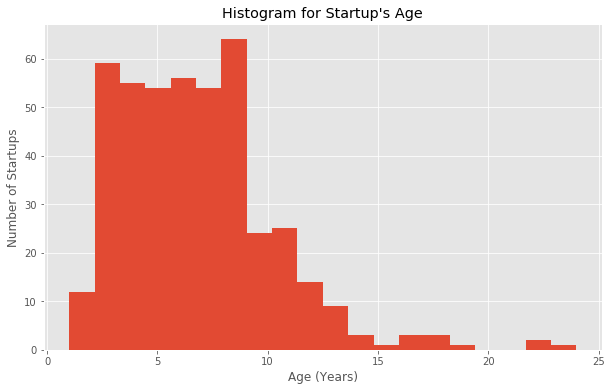

In [40]:
# Check the age distribution of the startups using histogram
ax = df_raw[(df_raw['age'] > 0)]['age'].hist(bins=20, figsize=(10, 6))
ax.set_title("Histogram for Startup's Age")
ax.set_xlabel("Age (Years)")
ax.set_ylabel("Number of Startups")

Text(0.5,0,'Age (Years)')

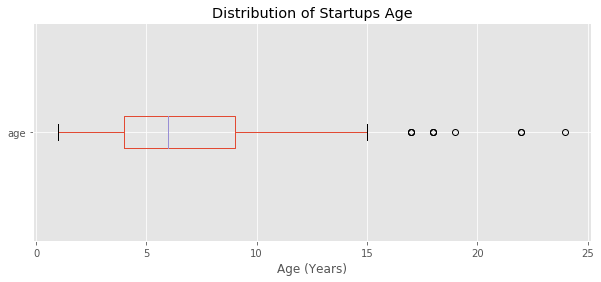

In [42]:
# Check the age distribution of the startups using box plot
ax = df_raw[(df_raw['age'] > 0)]['age'].plot.box(vert=False, figsize=(10, 4))
ax.set_title("Distribution of Startups Age")
ax.set_xlabel("Age (Years)")

In [43]:
# Get the quantiles for the age
df_raw[(df_raw['age'] > 0)]['age'].describe()

count    440.000000
mean       6.806818
std        3.448475
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       24.000000
Name: age, dtype: float64

In [45]:
# How many startups have age more than 15 years
df_raw[df_raw['age'] > 15].shape

(10, 10)

- The age of a typical startup is 6 years. Minimum and Maximum being 1 year and 15 years.
- [TODO] There are few (10 in number) start ups with age more than 15 years (Outliers?)

### 3.2 location of the startups

In [46]:
# Check for missing values for locations
df_raw[df_raw['location'].isnull()].shape

(10, 10)

In [47]:
# Replace the missing values with the string "Unknown Location"
df_raw['location'].fillna('Unknown Location', inplace=True)

In [49]:
# From how many cities?
len(df_raw.location.unique())

84

#### Generate a wordclod for the location. That will give some idea about the geographical spread of that data.

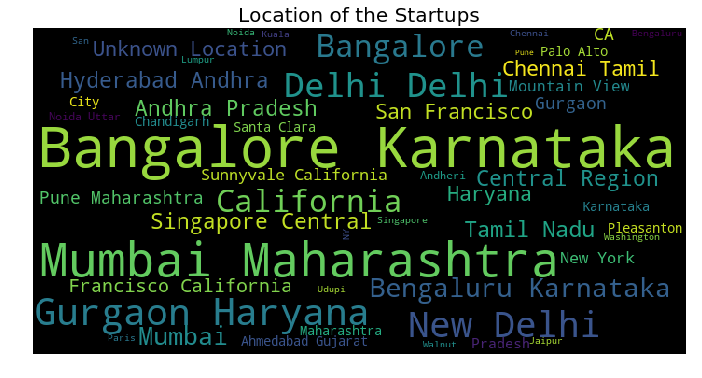

In [50]:
# Generate a wordcloud for the locations
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='black', width=700, height=350, max_font_size=60, max_words=50).generate(' '.join(df_raw.location))
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Location of the Startups", fontsize=20)
plt.axis("off")
plt.show()

#### From the wordcloud, it seems most of the startups are from India. Based on my knowledge about geography, I am going to MANUALLY add state and country for each city in India.

In [51]:
# At the end of this step all the cities from India will have corresponding state and country
df_raw.loc[df_raw.location.str.contains('Bangalore|Bengaluru|Kormangala|Whitefield'), 'location'] = 'Bangalore, Karnataka, India'
df_raw.loc[df_raw.location.str.contains('Tumkur'), 'location'] = 'Tumkur, Karnataka, India'
df_raw.loc[df_raw.location.str.contains('Udupi'), 'location'] = 'Udupi, Karnataka, India'

df_raw.loc[df_raw.location.str.contains('Mumbai'), 'location'] = 'Mumbai, Maharashtra, India'
df_raw.loc[df_raw.location.str.contains('Pune'), 'location'] = 'Pune, Maharashtra, India'
df_raw.loc[df_raw.location.str.contains('Andheri'), 'location'] = 'Andheri, Maharashtra, India'
df_raw.loc[df_raw.location.str.contains('Nagpur'), 'location'] = 'Nagpur, Maharashtra, India'

df_raw.loc[df_raw.location.str.contains('Delhi'), 'location'] = 'Delhi, Delhi, India'

df_raw.loc[df_raw.location.str.contains('Gurgaon'), 'location'] = 'Gurgaon, Haryana, India'
df_raw.loc[df_raw.location.str.contains('Faridabad'), 'location'] = 'Faridabad, Haryana, India'
df_raw.loc[df_raw.location.str.contains('Yamunanagar'), 'location'] = 'Yamunanagar, Haryana, India'

# Exact city name is not mentioned
df_raw.loc[df_raw.location =='Haryana, Haryana', 'location'] = 'Haryana, Haryana, India'
df_raw.loc[df_raw.location == 'Haryana', 'location'] = 'Haryana, Haryana, India'

df_raw.loc[df_raw.location.str.contains('Noida'), 'location'] = 'Noida, Uttar Pradesh, India'

df_raw.loc[df_raw.location.str.contains('Shimla'), 'location'] = 'Shimla, Himachal Pradesh, India'

df_raw.loc[df_raw.location.str.contains('Chandigarh'), 'location'] = 'Chandigarh, Chandigarh, India'

df_raw.loc[df_raw.location.str.contains('Chennai'), 'location'] = 'Chennai, Tamil Nadu, India'
df_raw.loc[df_raw.location.str.contains('Tirunelveli'), 'location'] = 'Tirunelveli, Tamil Nadu, India'
df_raw.loc[df_raw.location.str.contains('Taramani'), 'location'] = 'Taramani, Tamil Nadu, India'

df_raw.loc[df_raw.location.str.contains('Ahmedabad'), 'location'] = 'Ahmedabad, Gujarat, India'
df_raw.loc[df_raw.location.str.contains('Vadodara'), 'location'] = 'Vadodara, Gujarat, India'

df_raw.loc[df_raw.location.str.contains('Jaipur'), 'location'] = 'Jaipur, Rajasthan, India'

df_raw.loc[df_raw.location.str.contains('Hyderabad'), 'location'] = 'Hyderabad, Andhra Pradesh, India'

df_raw.loc[df_raw.location.str.contains('Kolkata'), 'location'] = 'Kolkata, West Bengal, India'

df_raw.loc[df_raw.location.str.contains('Indore'), 'location'] = 'Indore, Madhya Pradesh, India'

In [52]:
# Add three new columns called city, state, country for startups from India. 
df_raw["city"] = df_raw.location.apply(lambda x : x.split(",")[0].strip() if 'India' in x else np.NAN)
df_raw["state"] = df_raw.location.apply(lambda x : x.split(",")[1].strip() if 'India' in x else np.NAN)
df_raw["country"] = df_raw.location.apply(lambda x : x.split(",")[2].strip() if 'India' in x else np.NAN)

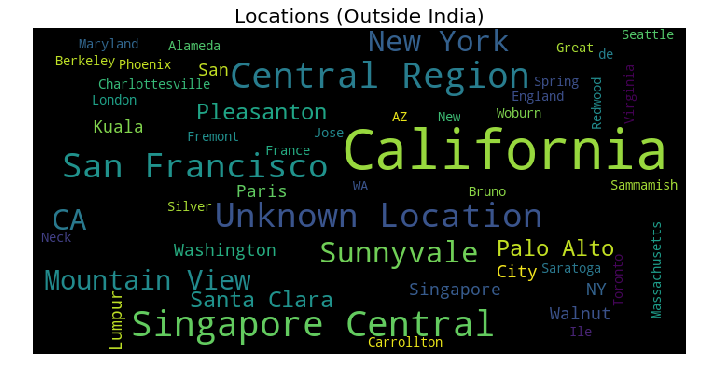

In [53]:
# For countries outside India, let me create a word cloud and check where are those located
df_locations_outside_india = df_raw[~(df_raw['country'] == "India")]
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='black', width=700, height=350, max_font_size=60, max_words=50).generate(' '.join(df_locations_outside_india.location))
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Locations (Outside India)", fontsize=20)
plt.axis("off")
plt.show()

#### It seems startups from outside India (present in the dataset) are mostly from USA, Singapore. 
- [TODO] Identify start ups from outside India by their City and State

In [54]:
# How many start ups from India
print("Start ups from India :", df_raw[df_raw["country"] == "India"].shape[0])
print("Start ups outside India (including Unknown Location) :", df_raw[~(df_raw["country"] == "India")].shape[0])

Start ups from India : 363
Start ups outside India (including Unknown Location) : 90


In [55]:
# Mark country for all the startups outside India as "Outside India"
df_raw.loc[~(df_raw["country"] == "India"), 'country'] = "Outside India"

#### Let me explore the startups inside India.

In [56]:
df_india = df_raw[df_raw["country"] == "India"]

#### Find out the Top 10 cities having most of the start ups.

Text(0.5,0,'Number of Startups')

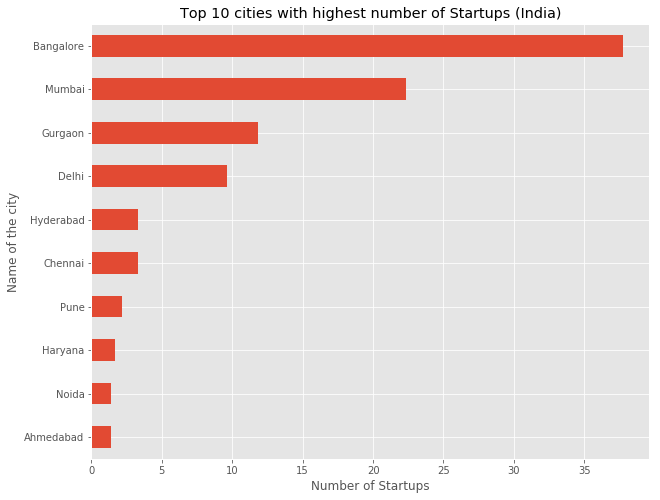

In [57]:
ax = ((df_india.city.value_counts()[0:10]/df_india.shape[0]) * 100).sort_values(ascending=True).plot.barh(figsize=(10, 8))
ax.set_title("Top 10 cities with highest number of Startups (India)")
ax.set_ylabel("Name of the city")
ax.set_xlabel("Number of Startups")

#### Note : Haryana shows up as as city. This is because for few of the startups from Haryana, city name is not mentioned in the dataset. For those startups, I have marked the city as Haryana to get some sense of location.

Text(0.5,0,'Number of Startups')

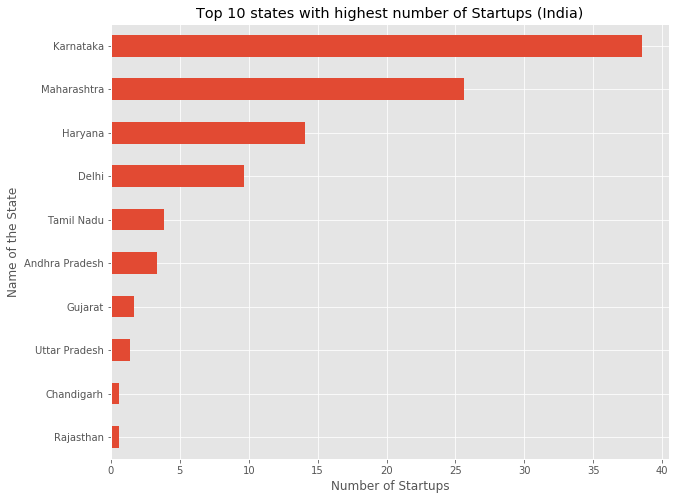

In [58]:
# Find out the states having most of the start ups.
ax = ((df_india.state.value_counts()[0:10]/df_india.shape[0]) * 100).sort_values(ascending=True).plot.barh(figsize=(10, 8))
ax.set_title("Top 10 states with highest number of Startups (India)")
ax.set_ylabel("Name of the State")
ax.set_xlabel("Number of Startups")

/home/arnab/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'Age (Years)')

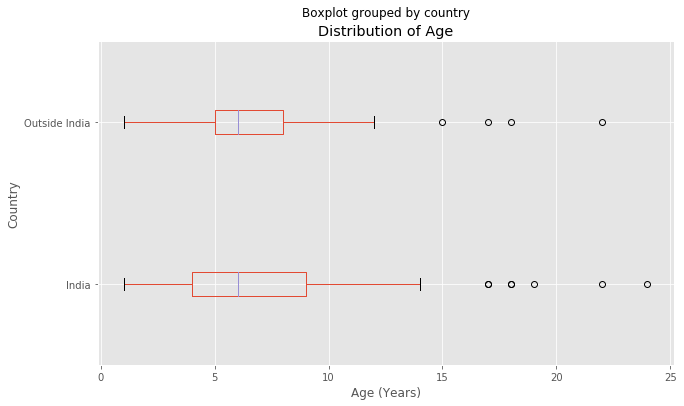

In [62]:
# Check if there is any drastic difference in the age of the startups within India and outside India
df_valid_age = df_raw[df_raw.age > 0]
ax = df_valid_age.boxplot(column='age', by='country', vert=False, figsize=(10, 6))
ax.set_title("Distribution of Age")
ax.set_ylabel("Country")
ax.set_xlabel("Age (Years)")

#### The boxplot does not indicate any drastic difference in the age distribution of the startups within and outside India. 
- [TODO] It could be interesting to see the difference across countries (India vs USA vs Singpore) provided we have sufficient number of data from different countries.

### 3.3 Employee Size

In [63]:
# Any missing value for employee count?
df_raw.employee_count.isnull().sum()

0

In [64]:
# How many employees do they have?
df_raw.employee_count.value_counts()

11 - 50    453
Name: employee_count, dtype: int64

#### Most of the startups have 11 to 50 employess. This is little surprising.

### 3.4 funding_data 

#### Let's check the total amount of funding for startups which has funding data

In [65]:
# Let me inspect funding information for one of the rows
# It looks like list of lists
df_raw.iloc[0].funding_data

"[['Nov, 2013', '$5.4M / Series B', '—', 'IvyCap Ventures', '3'], ['Mar, 2011', '$2.6M / Series A', '—', '—', '1'], ['Jan, 2008', '$3M / Series A', '—', '—', '1']]"

In [66]:
# But the type is actually String
type(df_raw.funding_data.iloc[0])

str

- I have refered to the crunchbase website to understand the structure of funding_data and investor_data
- crunchbase has two sections for each startups called "Funding Rounds" and "Investors". Information from these two sections have been scrapped into funding_data and investor_data column.
- As far as funding data is concerned, the outer list consists of information about multiple funding rounds.
- The inner lists consist of information about individual funding round. It follows the following format:
 
 [[date_of_investment, amount_invested(in dollar/euro/INR)/investment_round, '-', lead_investor_name, total_number_of_investors], [], ..]

In [67]:
# Check for missing values
df_raw.funding_data.isnull().sum()

50

In [68]:
# Fill all the missing funding data with string representing empty list
# This will help in the next step while converting the strings into lists
df_raw.funding_data.fillna("[]", inplace=True)

In [69]:
# Let's convert the strings to list of lists
df_raw.funding_data = df_raw[~(df_raw.funding_data.isnull())].funding_data.apply(lambda x : ast.literal_eval(x))

#### At this stage, all the missing values for funding_data has been replaced with empty lists.

#### I am creating a new column called round_of_funding. This should be equal to the number of lists inside the outer list. 

In [70]:
# How many rounds of funding?
df_raw["round_of_funding"] = df_raw[~(df_raw.funding_data.isnull())].funding_data.apply(lambda x : len(x))

In [72]:
# Take a look of the dataframe
df_raw.head(2)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases,age,city,state,country,round_of_funding
0,Aujas Networks,2008-01-01,11 - 50,Aujas Networks Pvt. Ltd. offers info...,"Bangalore, Karnataka, India","Security, Cloud Security, Informatio...","[[Nov, 2013, $5.4M / Series B, —, Iv...","[['IDG Ventures India', 'Series A', ...",NaN,10,Bangalore,Karnataka,India,3
1,CanvasFilp,2014-08-01,11 - 50,CanvasFlip is fastest growing protot...,"Bangalore, Karnataka, India",Software,"[[Sep, 2015, $1.2M / Seed, —, —, 2]]","[['Bessemer Venture Partners', 'Seed...",NaN,4,Bangalore,Karnataka,India,1


#### All the rows which have 0 as round_of_funding are associated with missing values.

#### How many rounds of funding a typical startup receives?

Text(0,0.5,'Number of Startups')

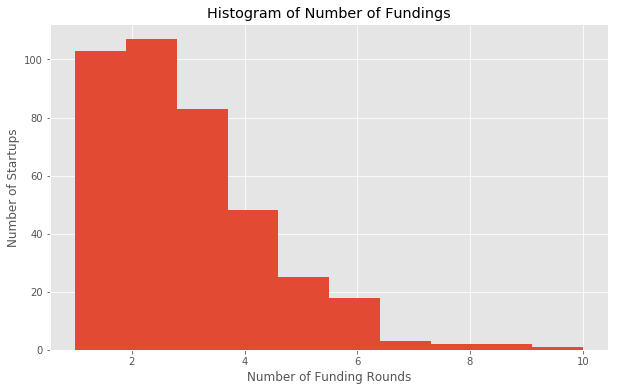

In [73]:
# How many rounds of funding a typical starup receives?

# Consider the startups with valid age and valid rounds of fundings (without missing values)
df_valid_age_funding = df_raw[(df_raw.round_of_funding > 0) & (df_raw.age > 0)]
ax = df_valid_age_funding['round_of_funding'].hist(figsize=(10, 6))
ax.set_title("Histogram of Number of Fundings")
ax.set_xlabel("Number of Funding Rounds")
ax.set_ylabel("Number of Startups")

Text(0.5,0,'Number of Funding Rounds')

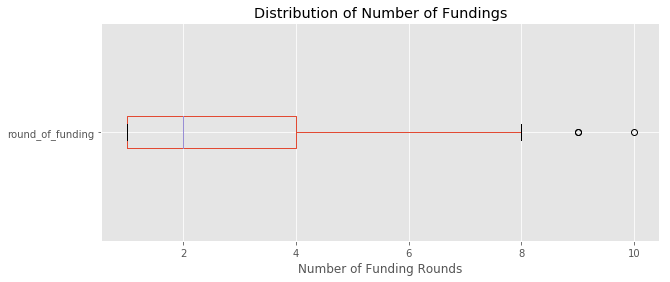

In [77]:
# Use a boxplot to understand the same data
ax = df_valid_age_funding['round_of_funding'].plot.box(vert=False, figsize=(10, 4), legend=False)
ax.set_title("Distribution of Number of Fundings")
ax.set_xlabel("Number of Funding Rounds")

In [78]:
df_valid_age_funding.round_of_funding.describe()

count    392.000000
mean       2.693878
std        1.608215
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: round_of_funding, dtype: float64

- A typical startup (Median) receives 2 rounds of funding
- All the startups have received atleast one round of funding
- There are startups which have received 10 rounds of funding as well

#### Check if there is any relationship between age and round of funding

Text(0.5,0,'Age (Year)')

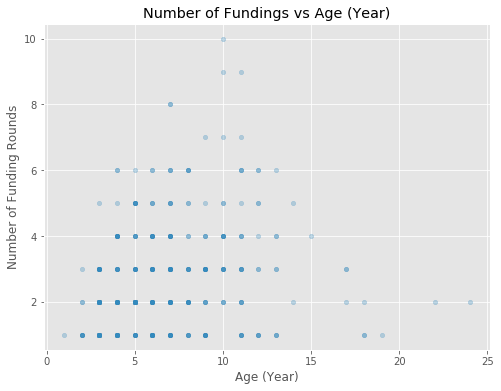

In [79]:
# Density of each points indicates number of points coinciding at that point
ax = df_valid_age_funding.plot.scatter('age', 'round_of_funding', figsize=(8, 6), legend=False, alpha=0.3)
ax.set_title("Number of Fundings vs Age (Year)")
ax.set_ylabel("Number of Funding Rounds")
ax.set_xlabel("Age (Year)")

#### Observations
- There is no linear relationship between the age and rounds of funding of the startups

Text(0,0.5,'Number of Startups')

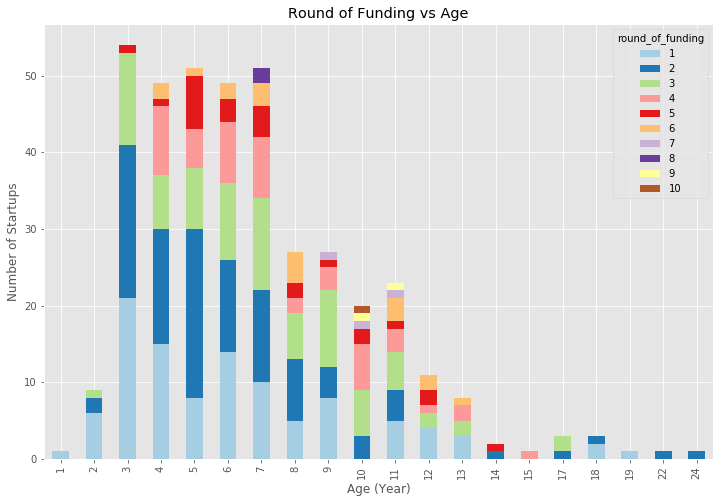

In [80]:
# Plot a stacked barplot to understand the relationship better
df = df_valid_age_funding.groupby(['age', 'round_of_funding'])['age'].count().unstack('round_of_funding').fillna(0)
ax = df[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]].plot(kind='bar', stacked=True, colormap='Paired', figsize=(12, 8))
ax.set_title("Round of Funding vs Age")
ax.set_xlabel('Age (Year)')
ax.set_ylabel('Number of Startups')

For startups of age 2
    - 1 startup received 3 rounds of funding
    - 2 startups received 2 rounds of funding
    - 6 startups received 1 rounds of funding
For startups of age 3
    - 1 startups received 5 rounds of funding
    - 12 startups received 3 rounds of funding
    - 20 startups received 2 rounds of funding
    - 21 startups received 1 rounds of funding
    
Startups with age more than 15 years
    - [TODO] Received upto 4 rounds of funding. Need to inspect those startups 

### How much of funding (in million dollars) startups have received over time?
- Undisclosed amount has been considered as 0
- Other currencies have been converted into dollar values

In [81]:
# Let's take a look of the funding information for one of the rows
df_raw.iloc[9].funding_data

[['Dec, 2016', 'undisclosed amount / Non Equity Assistance', '—', '—', '1'],
 ['Mar, 2014', '$3M / Series A', '—', 'Kalaari Capital', '1'],
 ['Jan, 2013', '$2.4M / Angel', '—', '—', '0']]

In [82]:
# Dollar to Indian Rupee conversion amount
dollar_to_indian_rupee = 65.0
# Dollar to Euro conversion amount
euro_to_dollar = 1.23

def calculate_sum_of_funding(funding_data_list):
    '''
    Calculate the total sum of fundings over multiple rounds 
    '''
    funding_list = [value_of_currency(parent[1].split("/")[0].strip()) for parent in funding_data_list]
    return sum(funding_list)

def value_of_currency(s):
    '''
    Converts different currencies to dollar values
    For example, 
        $2.4 M will be converted into 2.4
    '''
    if "$" in s:
        return value_to_float(s.replace("$", ""))
    elif "₹" in s:
        return value_to_float(s.replace("₹", ""))/dollar_to_indian_rupee
    elif "€" in s:
        return value_to_float(s.replace("€", ""))* euro_to_dollar
    elif "undisclosed amount" in s:
        return 0.0
    else:
        print(s)
        
def value_to_float(x):
    '''
    Converts the strings holding the amount into millions (numeric)
    '''
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) / 1000
        return 1000.0
    elif 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) / 1000
        return 1000.0
    elif 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', ''))
        return 1000000.0
    elif 'B' in x:
        return float(x.replace('B', '')) * 1000
    else:
        print("There is a problem", x)
        
    return 0.0

#### Add a new column with Total amount of (disclosed) funding over multiple rounds in millions dollars (M)

In [83]:
# Total amount of (disclosed) funding over multiple rounds in millions dollars (M)
df_raw['total_disclosed_funding'] = df_raw.funding_data.apply(lambda x : calculate_sum_of_funding(x))

#### There are startups for which number of funding rounds is non-zero, but total_disclosed_funding is zero. Check few of those.

In [84]:
df_raw[(df_raw.round_of_funding != 0) & (df_raw.total_disclosed_funding == 0)]["funding_data"].head(3)

13    [[Feb, 2016, undisclosed amount / Ve...
19    [[Feb, 2015, undisclosed amount / An...
34    [[Jun, 2017, undisclosed amount / Un...
Name: funding_data, dtype: object

#### A quick check shows that these startups have not disclosed any funding amount. How many such are there?

In [85]:
# How many startups are there for which none of the funding amount has been disclosed,
# but actully the startups has received funding 
df_raw[(df_raw.round_of_funding != 0) & (df_raw.total_disclosed_funding == 0)].shape[0]

64

In [86]:
df_raw[(df_raw.round_of_funding != 0) & (df_raw.total_disclosed_funding == 0)].country.value_counts()

India            58
Outside India     6
Name: country, dtype: int64

#### Most of these startups with undisclosed funding amounts are from India
- [TODO] Which sector do they belong to? 

#### I want to explore the startups which has disclosed their funding amount

In [87]:
# Get the startups which has valid information about round of funding and have disclosed their funding information
df_valid_funding = df_raw[(df_raw.round_of_funding > 0) & (df_raw.total_disclosed_funding > 0)]

In [88]:
# Take a look
df_valid_funding.head(3)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases,age,city,state,country,round_of_funding,total_disclosed_funding
0,Aujas Networks,2008-01-01,11 - 50,Aujas Networks Pvt. Ltd. offers info...,"Bangalore, Karnataka, India","Security, Cloud Security, Informatio...","[[Nov, 2013, $5.4M / Series B, —, Iv...","[['IDG Ventures India', 'Series A', ...",NaN,10,Bangalore,Karnataka,India,3,11.0
1,CanvasFilp,2014-08-01,11 - 50,CanvasFlip is fastest growing protot...,"Bangalore, Karnataka, India",Software,"[[Sep, 2015, $1.2M / Seed, —, —, 2]]","[['Bessemer Venture Partners', 'Seed...",NaN,4,Bangalore,Karnataka,India,1,1.2
3,Cloudcherry,2013-09-05,11 - 50,Cloudcherry was founded in 2013 with...,"Singapore, Central Region","Cloud Computing, Analytics, Apps, Mo...","[[Sep, 2016, $6M / Series A, —, —, 3...","[['Chennai Angels', 'Seed', '-'], ['...",NaN,5,NaN,NaN,Outside India,3,7.0


Text(0.5,0,'Funding Received (Million $)')

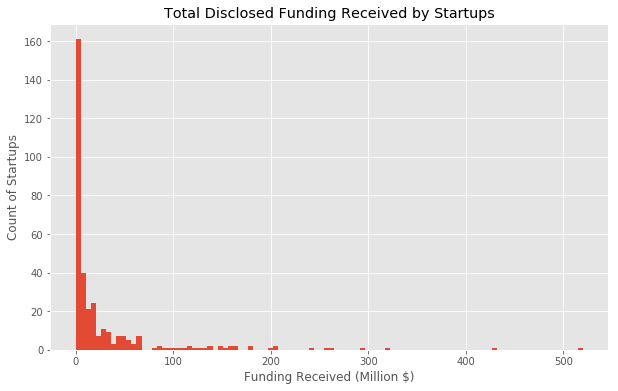

In [89]:
ax = df_valid_funding['total_disclosed_funding'].hist(bins=100, figsize=(10, 6))
ax.set_title('Total Disclosed Funding Received by Startups')
ax.set_ylabel('Count of Startups')
ax.set_xlabel('Funding Received (Million $)')

Text(0.5,0,'Funding Received (Million $)')

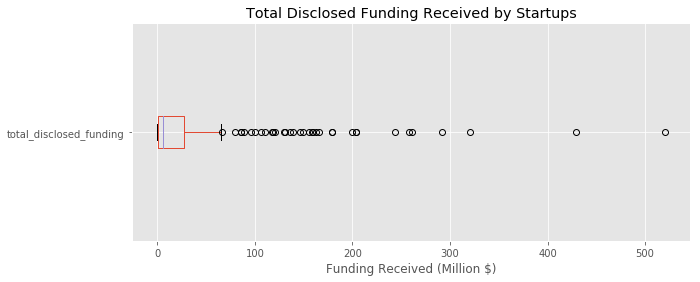

In [93]:
ax = df_valid_funding['total_disclosed_funding'].plot.box(vert=False, figsize=(10, 4), legend=False)
ax.set_title('Total Disclosed Funding Received by Startups')
ax.set_xlabel('Funding Received (Million $)')

In [94]:
df_valid_funding['total_disclosed_funding'].describe()

count    339.000000
mean      28.918883
std       60.266335
min        0.011700
25%        1.212500
50%        6.170000
75%       27.000000
max      520.000000
Name: total_disclosed_funding, dtype: float64

- The histogram is right skewed indicating most of the startups received smaller amount of funding where as very few startups received huge amount funding
- A typical start up (median) received 6.17 M as funding
- There are startups which has received funds between 100M to 500M (Outliers)

#### Any relationship between Age and funding received?

Text(0.5,0,'Age (Year)')

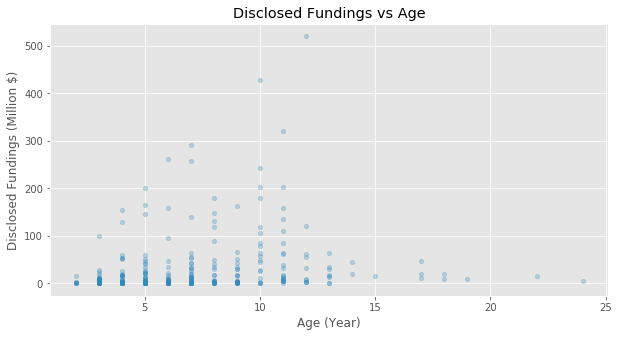

In [95]:
df_valid_age_funding = df_valid_funding[df_valid_funding['age'] > 0]
ax = df_valid_age_funding.plot.scatter('age', 'total_disclosed_funding', figsize=(10, 5), alpha=0.3)
ax.set_title("Disclosed Fundings vs Age")
ax.set_ylabel("Disclosed Fundings (Million $)")
ax.set_xlabel("Age (Year)")

- Observation
    - I would have been happy to see that with age, amount of funding is linearly increasing. But that is not the case.
    - The relationship between age and funding received is not linear in general
    - Starups which are 11 years or older has not received large amount of funding 
        - [TODO] Identify the sectors for the outliers

# 3.5 Investor data

In [96]:
# Take a look. Like funding data it also looks like list of lists
df_raw.iloc[0].investor_data

"[['IDG Ventures India', 'Series A', 'TC Meenakshisundaram', 'Series A', 'TC Meenakshisundaram', 'Series B', 'TC Meenakshisundaram'], ['IvyCap Ventures', 'Series B\\xa0(Lead)', 'Vikram GuptaNorbert Fernandes'], ['Rajasthan Venture Capital Fund', 'Series B', 'Girish Gupta']]"

- Here also, I have taken help of the crunchbase portal to understand the structure of the data (Investors Sestion)
- Data Format
   [[investor_name, funding_round, partner_name, funding_round, ..], [], ..]

In [97]:
# For how many rows there are missing values
df_raw[df_raw.investor_data.isnull()].shape[0]

59

In [99]:
# Replace missing values with string representing empty list. This is going to help in the next step
df_raw.investor_data.fillna("[]", inplace=True)

In [100]:
# Convert the string into list of lists objects
df_raw.investor_data = df_raw.investor_data.apply(lambda x : ast.literal_eval(x))

#### Create a new feature called number of investors

In [101]:
# Create a new feature called number of investors. That should the number of lists inside the outer list
df_raw['number_of_investors'] = df_raw.investor_data.apply(lambda x : len(x))

In [103]:
# We will consider all the startups for which number of investors is more than zero (Exclude missing value cases)
df_valid_funding_investor = df_raw[(df_raw.number_of_investors > 0) & (df_raw.round_of_funding > 0)]

Text(0,0.5,'Number of Startups')

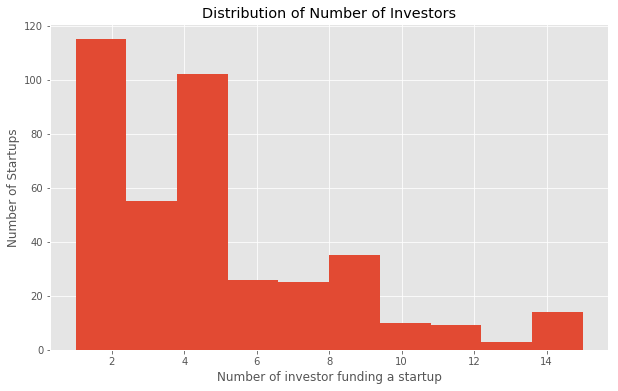

In [106]:
# Histogram of number of investors
ax = df_valid_funding_investor['number_of_investors'].hist(bins=10, figsize=(10, 6))
ax.set_title("Distribution of Number of Investors")
ax.set_xlabel("Number of investor funding a startup")
ax.set_ylabel("Number of Startups")

Text(0.5,0,'Number of Investors')

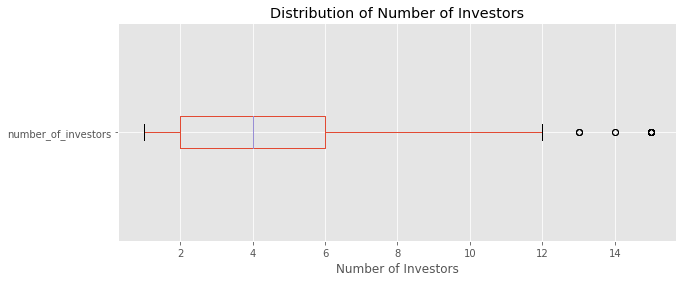

In [107]:
ax = df_valid_funding_investor['number_of_investors'].plot.box(vert=False, figsize=(10, 4), legend=False)
ax.set_title("Distribution of Number of Investors")
ax.set_xlabel("Number of Investors")

In [108]:
df_valid_funding_investor['number_of_investors'].describe()

count    394.000000
mean       4.728426
std        3.312380
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       15.000000
Name: number_of_investors, dtype: float64

- Observations
    - Distribution is rightly skewed. A typical startup has attracted 4 investors
    - There are startups which has been funded by 12+ investors
        - [TODO] Check those startups

Text(0.5,0,'Number of Investors')

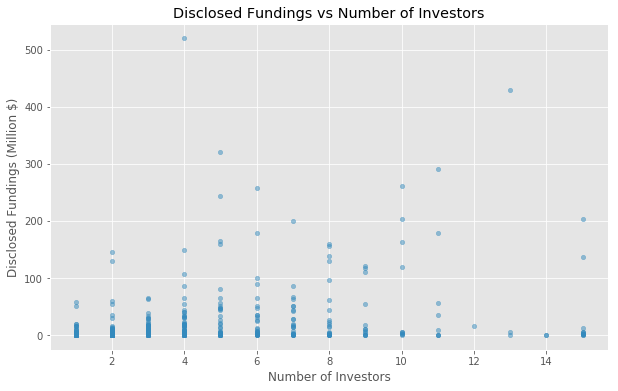

In [109]:
# Relationship between Number of investors and funding amount
ax = df_valid_funding_investor.plot.scatter("number_of_investors", "total_disclosed_funding", alpha=0.5, figsize=(10, 6), legend=False)
ax.set_title("Disclosed Fundings vs Number of Investors")
ax.set_ylabel("Disclosed Fundings (Million $)")
ax.set_xlabel("Number of Investors")

In [110]:
# Let's check what are the different columns that has been added so far
df_raw.columns

Index(['name', 'founded_date', 'employee_count', 'description', 'location',
       'categories', 'funding_data', 'investor_data', 'aliases', 'age', 'city',
       'state', 'country', 'round_of_funding', 'total_disclosed_funding',
       'number_of_investors'],
      dtype='object')

#### So far we have added following new features
- aliases
- age
- city
- state
- country
- round_of_funding
- total_disclosed_funding
- number_of_investors

# 3.6 Categories

In [111]:
# Check for missing values
df_raw[df_raw.categories.isnull()].shape[0]

5

In [112]:
# Replace the missing values with Unknown category
df_raw.categories.fillna("Unknown Categories", inplace=True)

#### Categories are represented as comma separated values. Flatten those and represent as dummy variables

In [113]:
# Convert comma separated string into list object after stripping spaces in-between
temp_series = df_raw.categories.apply(lambda x : [name.strip() for name in x.split(",")])
# Merge the categories as dummies to the original dataframe
df_raw = pd.concat([df_raw, pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)], axis=1)

In [114]:
# Take a look of extra columns
df_raw.head(3)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases,age,city,state,country,round_of_funding,total_disclosed_funding,number_of_investors,Accounting,Ad Network,Ad Retargeting,Ad Targeting,Adventure Travel,Advertising,Advertising Platforms,Agriculture,Analytics,Android,App Marketing,Apps,Art,Artificial Intelligence,Auctions,Automotive,B2B,Baby,Banking,Beauty,Big Data,Billing,Biometrics,Biotechnology,Bitcoin,Blogging Platforms,Brand Marketing,Browser Extensions,Building Material,Business Development,Business Intelligence,CRM,Car Sharing,Career Planning,Child Care,Children,Classifieds,Clean Energy,CleanTech,Cloud Computing,Cloud Data Services,Cloud Security,Cloud Storage,Collaboration,Commercial Real Estate,Communities,Compliance,Computer,Computer Vision,Construction,Consulting,Consumer,Consumer Electronics,Consumer Lending,Content,Content Delivery Network,Cooking,Corporate Training,Coupons,Coworking,Credit,Crowdfunding,Crowdsourcing,Customer Service,Cyber Security,Data Center Automation,Data Integration,Data Mining,Data Storage,Data Visualization,Database,Dating,Delivery,Delivery Service,Dental,Developer APIs,Developer Platform,Developer Tools,Dietary Supplements,Digital Entertainment,Digital Marketing,Digital Media,Direct Sales,Drones,E-Commerce,E-Commerce Platforms,E-Learning,E-Signature,EBooks,EdTech,Education,Electric Vehicle,Electrical Distribution,Electronics,Email,Email Marketing,Emerging Markets,Employment,Energy,Energy Management,Energy Storage,Enterprise Applications,Enterprise Software,Event Management,Events,Eyewear,Fashion,Field Support,File Sharing,FinTech,Finance,Financial Exchanges,Financial Services,Fitness,Food Delivery,Food Processing,Food and Beverage,Fraud Detection,Freemium,Fruit,Furniture,Gamification,Gaming,Genetics,Geospatial,Gift Card,Government,Grocery,Guides,Handmade,Hardware,Health Care,Health Diagnostics,Higher Education,Home Decor,Home Renovation,Home Services,Hospital,Hospitality,Hotel,Housekeeping Service,Human Resources,ICT,ISP,Industrial,Industrial Automation,Industrial Manufacturing,Information Services,Information Technology,Infrastructure,Insurance,Intellectual Property,Intelligent Systems,Interior Design,Internet,Internet of Things,Jewelry,Knowledge Management,Language Learning,Leisure,Lending,Lifestyle,Local,Location Based Services,Logistics,Loyalty Programs,Machine Learning,Management Information Systems,Manufacturing,Marketing,Marketing Automation,Marketplace,Media and Entertainment,Medical,Medical Device,Meeting Software,Messaging,Mobile,Mobile Advertising,Mobile Apps,Mobile Devices,Mobile Payments,Mothers,Music,Music Streaming,Natural Language Processing,Navigation,Network Security,News,Nightclubs,Office Administration,Online Forums,Online Portals,Open Source,Operating Systems,Outdoor Advertising,Outsourcing,PC Games,PaaS,Payments,Personal Finance,Personalization,Pharmaceutical,Photography,Point of Sale,Predictive Analytics,Price Comparison,Printing,Product Design,Product Search,Productivity Tools,Professional Networking,Project Management,Property Development,Property Management,Public Relations,Public Transportation,Publishing,Real Estate,Real Time,Recruiting,Recycling,Renewable Energy,Rental,Rental Property,Reputation,Reservations,Resorts,Restaurants,Retail,Retail Technology,Ride Sharing,Risk Management,Robotics,SEO,SaaS,Sales,Sales Automation,Search Engine,Secondary Education,Security,Semiconductor,Service Industry,Shoes,Shopping,Skill Assessment,Small and Medium Businesses,Smart Home,Social,Social CRM,Social Entrepreneurship,Social Media,Social Media Management,Social Media Marketing,Social Network,Social News,Software,Software Engineering,Solar,Sports,Staffing Agency,Stock Exchanges,Subscription Service,Supply Chain Management,TV Production,Taxi Service,Telecommunications,Test and Measurement,Text Analytics,Textiles,Ticketing,Tourism,Toys,Training,Transaction Processing,Transportation,Travel,Tutoring,Universities,Unknown Categories,V

In [115]:
# Generate the list of categories
list_of_categories = temp_series.apply(pd.Series).stack().unique().tolist()

In [116]:
# How many categories are there?
print("There are {} new features representing categories".format(len(list_of_categories)))

There are 295 new features representing categories


In [117]:
# Check the most popular categories based on the number of startups
df_raw[list_of_categories].sum().sort_values(ascending=False)[0:10]

E-Commerce                79
Mobile                    59
Software                  55
Internet                  47
Analytics                 33
Apps                      32
Enterprise Software       30
Information Technology    27
Big Data                  24
SaaS                      24
dtype: int64

Text(0,0.5,'Name of the category')

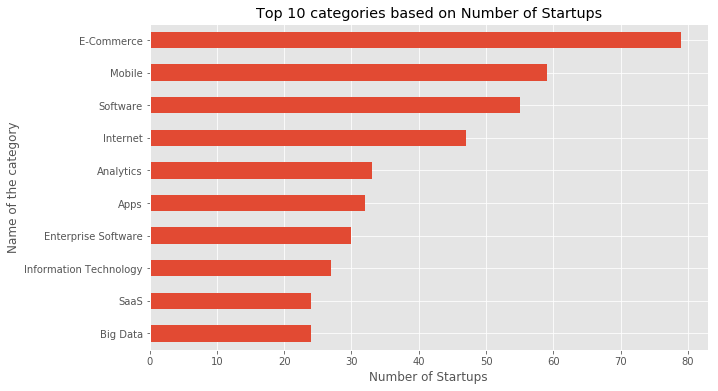

In [118]:
pop_categories = df_raw[list_of_categories].sum().sort_values(ascending=False)[0:10]
ax = pop_categories.sort_values().plot.barh(figsize=(10, 6))
ax.set_title("Top 10 categories based on Number of Startups")
ax.set_xlabel("Number of Startups")
ax.set_ylabel("Name of the category")

In [120]:
# Save the top 10 categories. It will be used in future
top_10_categories = pop_categories.index.tolist()

### Build a relation between total disclosed amount and categories

In [121]:
df_categories_funding = df_raw[['name', 'total_disclosed_funding', 'categories']]

In [122]:
df_categories_funding.head(3)

,name,total_disclosed_funding,categories
0,Aujas Networks,11.0,"Security, Cloud Security, Informatio..."
1,CanvasFilp,1.2,Software
2,Canvazify,0.0,Unknown Categories


In [123]:
temp_series = df_categories_funding.categories.apply(lambda x : [name.strip() for name in x.split(",")])
pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)
# Create a dataframe with investor name and different sectors as dummy variables
df_categories_funding_dummy = pd.concat([df_categories_funding, pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)], axis=1)

In [124]:
df_categories_funding_dummy.head(3)

,name,total_disclosed_funding,categories,Accounting,Ad Network,Ad Retargeting,Ad Targeting,Adventure Travel,Advertising,Advertising Platforms,Agriculture,Analytics,Android,App Marketing,Apps,Art,Artificial Intelligence,Auctions,Automotive,B2B,Baby,Banking,Beauty,Big Data,Billing,Biometrics,Biotechnology,Bitcoin,Blogging Platforms,Brand Marketing,Browser Extensions,Building Material,Business Development,Business Intelligence,CRM,Car Sharing,Career Planning,Child Care,Children,Classifieds,Clean Energy,CleanTech,Cloud Computing,Cloud Data Services,Cloud Security,Cloud Storage,Collaboration,Commercial Real Estate,Communities,Compliance,Computer,Computer Vision,Construction,Consulting,Consumer,Consumer Electronics,Consumer Lending,Content,Content Delivery Network,Cooking,Corporate Training,Coupons,Coworking,Credit,Crowdfunding,Crowdsourcing,Customer Service,Cyber Security,Data Center Automation,Data Integration,Data Mining,Data Storage,Data Visualization,Database,Dating,Delivery,Delivery Service,Dental,Developer APIs,Developer Platform,Developer Tools,Dietary Supplements,Digital Entertainment,Digital Marketing,Digital Media,Direct Sales,Drones,E-Commerce,E-Commerce Platforms,E-Learning,E-Signature,EBooks,EdTech,Education,Electric Vehicle,Electrical Distribution,Electronics,Email,Email Marketing,Emerging Markets,Employment,Energy,Energy Management,Energy Storage,Enterprise Applications,Enterprise Software,Event Management,Events,Eyewear,Fashion,Field Support,File Sharing,FinTech,Finance,Financial Exchanges,Financial Services,Fitness,Food Delivery,Food Processing,Food and Beverage,Fraud Detection,Freemium,Fruit,Furniture,Gamification,Gaming,Genetics,Geospatial,Gift Card,Government,Grocery,Guides,Handmade,Hardware,Health Care,Health Diagnostics,Higher Education,Home Decor,Home Renovation,Home Services,Hospital,Hospitality,Hotel,Housekeeping Service,Human Resources,ICT,ISP,Industrial,Industrial Automation,Industrial Manufacturing,Information Services,Information Technology,Infrastructure,Insurance,Intellectual Property,Intelligent Systems,Interior Design,Internet,Internet of Things,Jewelry,Knowledge Management,Language Learning,Leisure,Lending,Lifestyle,Local,Location Based Services,Logistics,Loyalty Programs,Machine Learning,Management Information Systems,Manufacturing,Marketing,Marketing Automation,Marketplace,Media and Entertainment,Medical,Medical Device,Meeting Software,Messaging,Mobile,Mobile Advertising,Mobile Apps,Mobile Devices,Mobile Payments,Mothers,Music,Music Streaming,Natural Language Processing,Navigation,Network Security,News,Nightclubs,Office Administration,Online Forums,Online Portals,Open Source,Operating Systems,Outdoor Advertising,Outsourcing,PC Games,PaaS,Payments,Personal Finance,Personalization,Pharmaceutical,Photography,Point of Sale,Predictive Analytics,Price Comparison,Printing,Product Design,Product Search,Productivity Tools,Professional Networking,Project Management,Property Development,Property Management,Public Relations,Public Transportation,Publishing,Real Estate,Real Time,Recruiting,Recycling,Renewable Energy,Rental,Rental Property,Reputation,Reservations,Resorts,Restaurants,Retail,Retail Technology,Ride Sharing,Risk Management,Robotics,SEO,SaaS,Sales,Sales Automation,Search Engine,Secondary Education,Security,Semiconductor,Service Industry,Shoes,Shopping,Skill Assessment,Small and Medium Businesses,Smart Home,Social,Social CRM,Social Entrepreneurship,Social Media,Social Media Management,Social Media Marketing,Social Network,Social News,Software,Software Engineering,Solar,Sports,Staffing Agency,Stock Exchanges,Subscription Service,Supply Chain Management,TV Production,Taxi Service,Telecommunications,Test and Measurement,Text Analytics,Textiles,Ticketing,Tourism,Toys,Training,Transaction Processing,Transportation,Travel,Tutoring,Universities,Unknown Categories,Venture Capital,Video,Video Games,Video Streaming,Video on Demand,Virtual Assistant,Virtualization,Waste Management,Wearables,Web Browsers,Web De

In [126]:
def get_investment_by_category(df, category_name):
    '''
    Given with a category name, return total amount of investment made across startups over time
    '''
    return df[df[category_name] > 0]['total_disclosed_funding'].sum()

#### Get the total investment over years across categories/sectors

In [127]:
print("Investment for Analytics : {}".format(get_investment_by_category(df_categories_funding_dummy, 'Analytics')))
print("Investment for E-Commerce : {}".format(get_investment_by_category(df_categories_funding_dummy, 'E-Commerce')))
print("Investment for Mobile : {}".format(get_investment_by_category(df_categories_funding_dummy, 'Mobile')))

Investment for Analytics : 703.8847000000002
Investment for E-Commerce : 2921.4339230769237
Investment for Mobile : 1926.6257146153841


Text(0.5,0,'Investment (Million $) ')

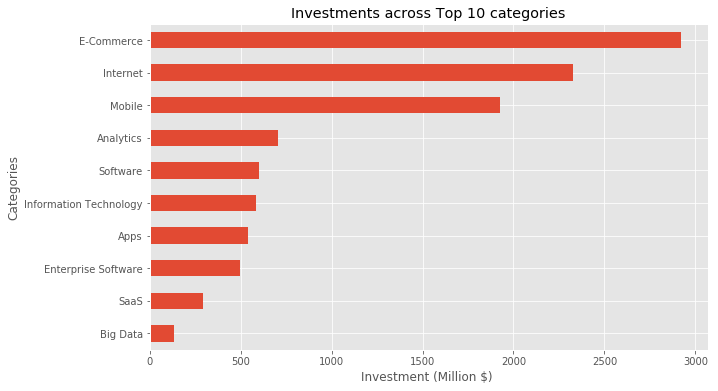

In [128]:
# Get the total investment over years across categories/sectors
dict_cat_by_investment = {}
for cat_name in top_10_categories:
    dict_cat_by_investment[cat_name] = get_investment_by_category(df_categories_funding_dummy, cat_name)
dict_cat_by_investment.keys()

df_cat_by_investment = pd.DataFrame()
df_cat_by_investment['category'] = dict_cat_by_investment.keys()
df_cat_by_investment['Disclosed_Funding'] = dict_cat_by_investment.values()
ax = df_cat_by_investment.sort_values('Disclosed_Funding').plot.barh('category', 'Disclosed_Funding', figsize=(10, 6), legend=False)
ax.set_title("Investments across Top 10 categories")
ax.set_ylabel("Categories")
ax.set_xlabel("Investment (Million $) ")

In [130]:
top_10_categories = df_raw[list_of_categories].sum().sort_values(ascending=False)[0:11].index.tolist()

#### Let me explore funding data further

In [131]:
# Create a dataframe from the funding lists only
funding_df = df_raw.set_index('categories')['funding_data'].apply(pd.Series).stack().reset_index()
funding_df.drop(labels='level_1', axis=1, inplace=True)
funding_df.columns = ['categories', 'funding_data']

In [132]:
# Take a look
funding_df.head(3)

,categories,funding_data
0,"Security, Cloud Security, Informatio...","[Nov, 2013, $5.4M / Series B, —, Ivy..."
1,"Security, Cloud Security, Informatio...","[Mar, 2011, $2.6M / Series A, —, —, 1]"
2,"Security, Cloud Security, Informatio...","[Jan, 2008, $3M / Series A, —, —, 1]"


In [133]:
# Different utility methods to extract funding information

def extact_date(funding_data):
    '''
    Extract date of investment
    '''
    if len(funding_data) > 0:
        return funding_data[0]

def extact_funding_amount(funding_data):
    '''
    Extract investment amount
    '''
    if len(funding_data) > 0:
        funding_string = funding_data[1].split("/")[0].strip()
        return value_of_currency(funding_string)
    
def extact_funding_round(funding_data):
    '''
    Extract round of investments
    '''
    if len(funding_data) > 0:
        return funding_data[1].split("/")[1].strip()

def extract_number_of_investors(funding_data):
    '''
    Extract number of investors
    '''
    if len(funding_data) > 0:
        return funding_data[4]
    
def extact_lead_investor(funding_data):
    '''
    Who is the lead investor?
    '''
    if len(funding_data) > 0:
        return funding_data[3]

In [135]:
# Create new features : date of funding, fudning amount, funding round, no of investors, lead investor
funding_df['date'] = funding_df['funding_data'].apply(extact_date)
funding_df['funding_amount'] = funding_df['funding_data'].apply(extact_funding_amount)
funding_df['funding_round'] = funding_df['funding_data'].apply(extact_funding_round)
funding_df['no_of_investors'] = funding_df['funding_data'].apply(extract_number_of_investors)
funding_df['lead_investor'] = funding_df['funding_data'].apply(extact_lead_investor)

In [136]:
# Take a look
funding_df.head()

,categories,funding_data,date,funding_amount,funding_round,no_of_investors,lead_investor
0,"Security, Cloud Security, Informatio...","[Nov, 2013, $5.4M / Series B, —, Ivy...","Nov, 2013",5.4,Series B,3,IvyCap Ventures
1,"Security, Cloud Security, Informatio...","[Mar, 2011, $2.6M / Series A, —, —, 1]","Mar, 2011",2.6,Series A,1,—
2,"Security, Cloud Security, Informatio...","[Jan, 2008, $3M / Series A, —, —, 1]","Jan, 2008",3.0,Series A,1,—
3,Software,"[Sep, 2015, $1.2M / Seed, —, —, 2]","Sep, 2015",1.2,Seed,2,—
4,"Cloud Computing, Analytics, Apps, Mo...","[Sep, 2016, $6M / Series A, —, —, 3]","Sep, 2016",6.0,Series A,3,—


In [137]:
# Convert date column to datetime format and then sort the dataframe based on date
funding_df.date = pd.to_datetime(funding_df.date)
funding_df.sort_values('date', inplace=True)

In [138]:
# Multiple fundings have been made on the same month/year?
funding_df[funding_df.duplicated('date')].shape[0]

953

#### Let me plot a time series with the amount invested by the investors in the market

Text(0,0.5,'Funding Amount (Million $)')

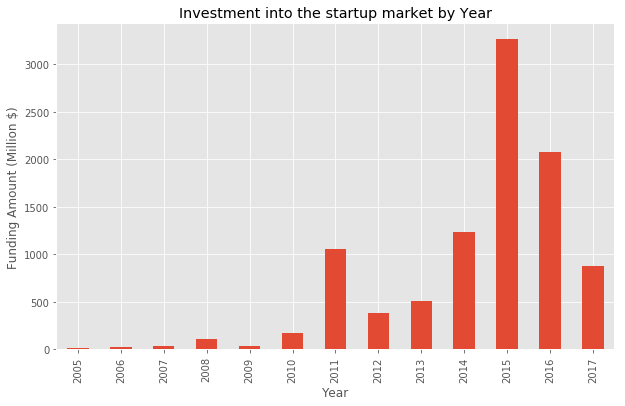

In [139]:
# Time Series plot for funding amount(in K)
ax = funding_df[['funding_amount', 'date']].groupby(funding_df['date'].dt.year).agg('sum').plot.bar(figsize=(10, 6), legend=False)
ax.set_title("Investment into the startup market by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Funding Amount (Million $)")

- Observation
    - There was a sudden spike in investment during 2011 (May be once market came out of 2008-09 financial crisis)
    - 2012 onwards amount invested in the market increased consistenly till 2015
    - After that investment is dropping over 2016 and 2017

Text(0,0.5,'Count')

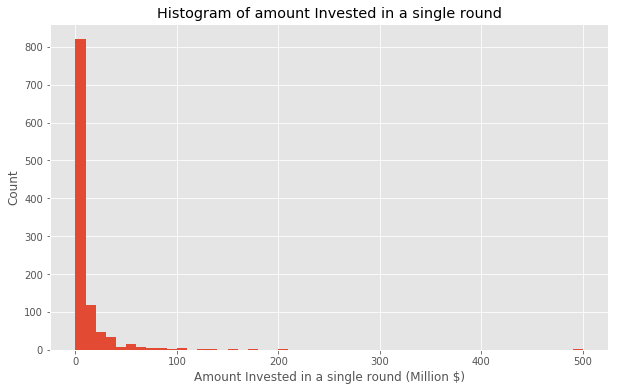

In [140]:
# Histogram of amount funded in a single round
ax = funding_df['funding_amount'].hist(figsize=(10, 6), bins=50)
ax.set_title("Histogram of amount Invested in a single round")
ax.set_xlabel("Amount Invested in a single round (Million $)")
ax.set_ylabel("Count")

Text(0.5,0,'Amount Invested in a single round (Million $)')

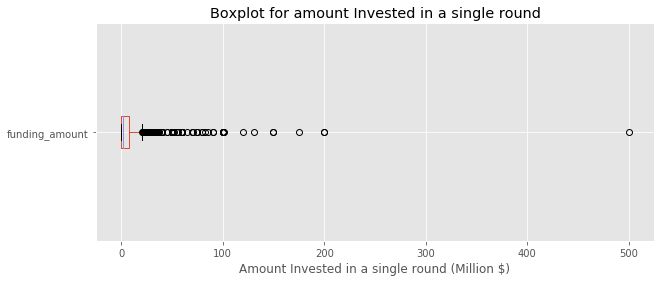

In [141]:
ax = funding_df['funding_amount'].plot.box(vert=False, figsize=(10, 4))
ax.set_title("Boxplot for amount Invested in a single round")
ax.set_xlabel("Amount Invested in a single round (Million $)")

In [142]:
# TODO : Write some conclusion
funding_df['funding_amount'].describe()

count    1073.000000
mean        9.136534
std        24.601482
min         0.000000
25%         0.000000
50%         1.700000
75%         8.000000
max       500.000000
Name: funding_amount, dtype: float64

- Observation
    - How much money is getting invested in a single round of funding.
    - This data is confusing as it included grants as well as normal investment rounds

Text(0,0.5,'Investment Amount (Millions $)')

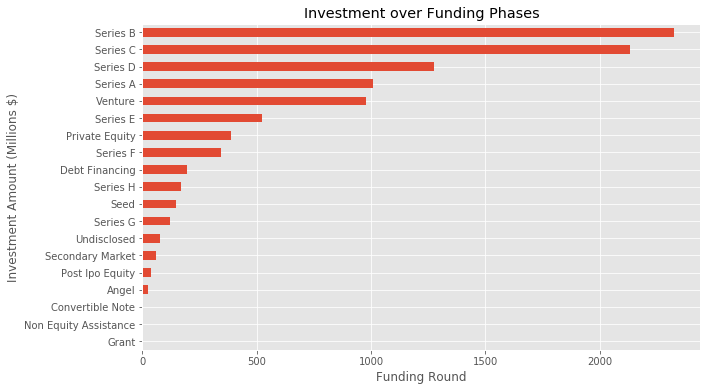

In [144]:
# Check how much money has been funded in which round of funding?
ax = funding_df[['funding_amount', 'funding_round']].groupby('funding_round').sum().sort_values('funding_amount', ascending=True).plot.barh(figsize=(10, 6), legend=False)
ax.set_title("Investment over Funding Phases")
ax.set_xlabel("Funding Round")
ax.set_ylabel("Investment Amount (Millions $)")

- Observation
    - Series B, C, D, A are the rounds when most of the money is pumped into the market

In [145]:
# Top investment companies who acted as Lead Invetsors
funding_df[~funding_df.lead_investor.str.contains("—")][['lead_investor', 'funding_amount']].groupby(['lead_investor']).sum().sort_values(by='funding_amount', ascending=False)[0:10]

,funding_amount
lead_investor,
Tiger Global Management,721.500000
Sequoia Capital,599.315385
D2 Communications,510.000000
SoftBank,339.700000
SoftBank Capital,305.000000
Warburg Pincus,237.769231
PremjiInvest,212.769231
Foxconn Technology GroupTencent Holdings,175.000000
Kinnevik ABTiger Global Management,150.000000


- Observation
    - This data is not complete as well. For lot of startups lead investor information is missing
    - I have not taken care of parsing investor names like this : Foxconn Technology GroupTencent Holdings

#### Let's check the time series for funding on  startups from different sectors (Is E-Commerce or Analytics trending?)

In [149]:
# Flatten the categories information as dummies
temp_series = funding_df.categories.apply(lambda x : [name.strip() for name in x.split(",")])
pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)
funding_df_categories_dummy = pd.concat([funding_df, pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)], axis=1)

Text(0,0.5,'Funding Amount (Million $)')

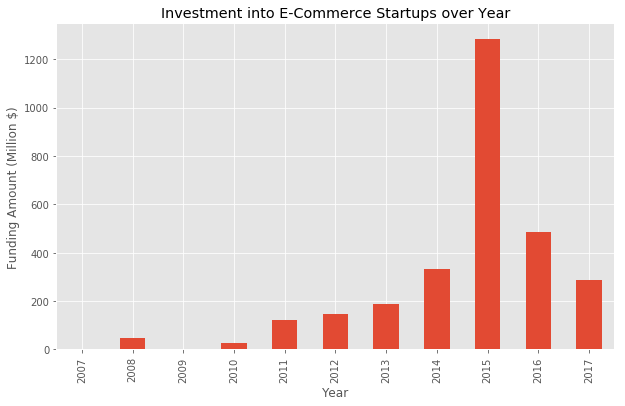

In [150]:
# Time series for E-Commerce startups
ax = funding_df_categories_dummy[funding_df_categories_dummy['E-Commerce'] > 0][['funding_amount', 'date']].groupby(funding_df['date'].dt.year).agg('sum').plot.bar(figsize=(10, 6), legend=False)
ax.set_title("Investment into E-Commerce Startups over Year")
ax.set_xlabel("Year")
ax.set_ylabel("Funding Amount (Million $)")

Text(0,0.5,'Funding Amount (Million $)')

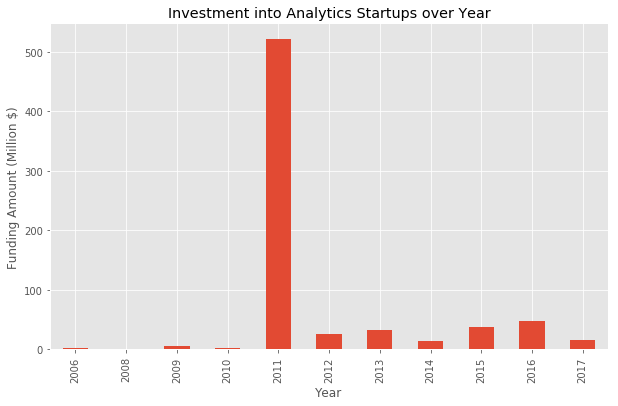

In [151]:
# Time series for Analytics startups
ax = funding_df_categories_dummy[funding_df_categories_dummy['Analytics'] > 0][['funding_amount', 'date']].groupby(funding_df['date'].dt.year).agg('sum').plot.bar(figsize=(10, 6), legend=False)
ax.set_title("Investment into Analytics Startups over Year")
ax.set_xlabel("Year")
ax.set_ylabel("Funding Amount (Million $)")

### I am going to focus on investor information now

- Understand the main investors in a particular sectors. For example, top 10 investors in the E-Commerce sector?

#### From df_raw get the categories and investor_data and then flatten those using dummy encoding

In [152]:
investor_df = df_raw.set_index('categories')['investor_data'].apply(pd.Series).stack().reset_index()
investor_df.drop(labels='level_1', axis=1, inplace=True)
investor_df.columns = ['categories', 'investor_data']

In [153]:
investor_df.head(2)

,categories,investor_data
0,"Security, Cloud Security, Informatio...","[IDG Ventures India, Series A, TC Me..."
1,"Security, Cloud Security, Informatio...","[IvyCap Ventures, Series B (Lead), V..."


In [154]:
# Utility method to extract investor information
def extract_investor_name(investor_data):
    return investor_data[0].strip()

def extarct_series_info(investor_data):
    series_list = investor_data[1::2]
    return [elem.replace("(Lead)", "").strip() for elem in series_list]

In [155]:
investor_df['investor_name'] = investor_df.investor_data.apply(extract_investor_name)
investor_df['series_invested'] = investor_df.investor_data.apply(extarct_series_info)

In [156]:
investor_df.head()

,categories,investor_data,investor_name,series_invested
0,"Security, Cloud Security, Informatio...","[IDG Ventures India, Series A, TC Me...",IDG Ventures India,"[Series A, Series A, Series B]"
1,"Security, Cloud Security, Informatio...","[IvyCap Ventures, Series B (Lead), V...",IvyCap Ventures,[Series B]
2,"Security, Cloud Security, Informatio...","[Rajasthan Venture Capital Fund, Ser...",Rajasthan Venture Capital Fund,[Series B]
3,Software,"[Bessemer Venture Partners, Seed, -]",Bessemer Venture Partners,[Seed]
4,Software,"[Microsoft Accelerator Bangalore, Se...",Microsoft Accelerator Bangalore,[Seed]


#### How many unique investors?

In [157]:
print("Number of unique of investors : {}".format(len(investor_df.investor_name.unique())))

Number of unique of investors : 838


##### Here I am creating a dataframe with investor_name as a column. Other columna are categories or investment rounds (dummy encoded)

In [158]:
temp_series = investor_df.categories.apply(lambda x : [name.strip() for name in x.split(",")])
# Create a dataframe with investor name and different sectors as dummy variables
investor_to_sector_dummy = pd.concat([investor_df['investor_name'], pd.get_dummies(temp_series.apply(pd.Series).stack()).sum(level=0)], axis=1)
# Create a DataFrame with investor_name and funding type as the features (Dummy Variable)
df_investor_to_series_dummy = pd.concat([investor_df['investor_name'], investor_df.series_invested.str.join('|').str.get_dummies()], axis=1)
# Now merge df_investor_to_series_dummy and investor_to_sector_dummy
investor_to_series_sector_dummies = pd.merge(df_investor_to_series_dummy, investor_to_sector_dummy, left_index=True, right_index=True,  suffixes=('', '_y')) 
investor_to_series_sector_dummies = investor_to_series_sector_dummies.drop(labels=['investor_name_y'], axis=1)

In [161]:
investor_to_sector_dummy.head(1)

,investor_name,Accounting,Ad Network,Ad Retargeting,Ad Targeting,Adventure Travel,Advertising,Advertising Platforms,Agriculture,Analytics,Android,App Marketing,Apps,Art,Artificial Intelligence,Auctions,Automotive,B2B,Baby,Banking,Beauty,Big Data,Billing,Biometrics,Biotechnology,Bitcoin,Blogging Platforms,Brand Marketing,Browser Extensions,Building Material,Business Development,Business Intelligence,CRM,Car Sharing,Career Planning,Child Care,Children,Classifieds,Clean Energy,CleanTech,Cloud Computing,Cloud Data Services,Cloud Security,Cloud Storage,Collaboration,Commercial Real Estate,Communities,Compliance,Computer,Computer Vision,Construction,Consulting,Consumer,Consumer Electronics,Consumer Lending,Content,Content Delivery Network,Cooking,Corporate Training,Coupons,Coworking,Credit,Crowdfunding,Crowdsourcing,Customer Service,Cyber Security,Data Center Automation,Data Integration,Data Mining,Data Storage,Data Visualization,Database,Dating,Delivery,Delivery Service,Dental,Developer APIs,Developer Platform,Developer Tools,Dietary Supplements,Digital Entertainment,Digital Marketing,Digital Media,Direct Sales,Drones,E-Commerce,E-Commerce Platforms,E-Learning,E-Signature,EBooks,EdTech,Education,Electric Vehicle,Electrical Distribution,Electronics,Email,Email Marketing,Emerging Markets,Employment,Energy,Enterprise Applications,Enterprise Software,Event Management,Events,Eyewear,Fashion,Field Support,File Sharing,FinTech,Finance,Financial Exchanges,Financial Services,Fitness,Food Delivery,Food Processing,Food and Beverage,Fraud Detection,Freemium,Fruit,Furniture,Gamification,Gaming,Genetics,Geospatial,Gift Card,Government,Grocery,Guides,Handmade,Hardware,Health Care,Health Diagnostics,Higher Education,Home Decor,Home Renovation,Home Services,Hospital,Hospitality,Hotel,Housekeeping Service,Human Resources,ICT,ISP,Industrial,Industrial Automation,Industrial Manufacturing,Information Services,Information Technology,Infrastructure,Insurance,Intellectual Property,Interior Design,Internet,Internet of Things,Jewelry,Knowledge Management,Language Learning,Leisure,Lending,Lifestyle,Local,Location Based Services,Logistics,Loyalty Programs,Machine Learning,Management Information Systems,Manufacturing,Marketing,Marketing Automation,Marketplace,Media and Entertainment,Medical,Medical Device,Meeting Software,Messaging,Mobile,Mobile Advertising,Mobile Apps,Mobile Payments,Mothers,Music,Music Streaming,Natural Language Processing,Navigation,Network Security,News,Nightclubs,Office Administration,Online Forums,Online Portals,Open Source,Operating Systems,Outsourcing,PC Games,PaaS,Payments,Personal Finance,Personalization,Pharmaceutical,Photography,Point of Sale,Predictive Analytics,Price Comparison,Printing,Product Design,Product Search,Productivity Tools,Professional Networking,Property Development,Property Management,Public Relations,Public Transportation,Publishing,Real Estate,Real Time,Recruiting,Recycling,Renewable Energy,Rental,Rental Property,Reservations,Resorts,Restaurants,Retail,Retail Technology,Ride Sharing,Risk Management,Robotics,SEO,SaaS,Sales,Sales Automation,Search Engine,Secondary Education,Security,Semiconductor,Service Industry,Shoes,Shopping,Skill Assessment,Small and Medium Businesses,Smart Home,Social,Social Entrepreneurship,Social Media,Social Media Management,Social Media Marketing,Social Network,Social News,Software,Software Engineering,Solar,Sports,Staffing Agency,Subscription Service,Supply Chain Management,TV Production,Taxi Service,Telecommunications,Test and Measurement,Text Analytics,Textiles,Ticketing,Tourism,Toys,Training,Transaction Processing,Transportation,Travel,Tutoring,Universities,Unknown Categories,Venture Capital,Video,Video Games,Video Streaming,Video on Demand,Virtual Assistant,Virtualization,Waste Management,Wearables,Web Browsers,Web Development,Wellness,Windows Phone,Wireless,iOS
0,IDG Ventures India,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [163]:
investor_to_series_sector_dummies.head(1)

,investor_name,Angel,Convertible Note,Debt Financing,Grant,Non Equity Assistance,Post Ipo Equity,Private Equity,Secondary Market,Seed,Series A,Series B,Series C,Series D,Series E,Series F,Series G,Series H,Undisclosed,Venture,Accounting,Ad Network,Ad Retargeting,Ad Targeting,Adventure Travel,Advertising,Advertising Platforms,Agriculture,Analytics,Android,App Marketing,Apps,Art,Artificial Intelligence,Auctions,Automotive,B2B,Baby,Banking,Beauty,Big Data,Billing,Biometrics,Biotechnology,Bitcoin,Blogging Platforms,Brand Marketing,Browser Extensions,Building Material,Business Development,Business Intelligence,CRM,Car Sharing,Career Planning,Child Care,Children,Classifieds,Clean Energy,CleanTech,Cloud Computing,Cloud Data Services,Cloud Security,Cloud Storage,Collaboration,Commercial Real Estate,Communities,Compliance,Computer,Computer Vision,Construction,Consulting,Consumer,Consumer Electronics,Consumer Lending,Content,Content Delivery Network,Cooking,Corporate Training,Coupons,Coworking,Credit,Crowdfunding,Crowdsourcing,Customer Service,Cyber Security,Data Center Automation,Data Integration,Data Mining,Data Storage,Data Visualization,Database,Dating,Delivery,Delivery Service,Dental,Developer APIs,Developer Platform,Developer Tools,Dietary Supplements,Digital Entertainment,Digital Marketing,Digital Media,Direct Sales,Drones,E-Commerce,E-Commerce Platforms,E-Learning,E-Signature,EBooks,EdTech,Education,Electric Vehicle,Electrical Distribution,Electronics,Email,Email Marketing,Emerging Markets,Employment,Energy,Enterprise Applications,Enterprise Software,Event Management,Events,Eyewear,Fashion,Field Support,File Sharing,FinTech,Finance,Financial Exchanges,Financial Services,Fitness,Food Delivery,Food Processing,Food and Beverage,Fraud Detection,Freemium,Fruit,Furniture,Gamification,Gaming,Genetics,Geospatial,Gift Card,Government,Grocery,Guides,Handmade,Hardware,Health Care,Health Diagnostics,Higher Education,Home Decor,Home Renovation,Home Services,Hospital,Hospitality,Hotel,Housekeeping Service,Human Resources,ICT,ISP,Industrial,Industrial Automation,Industrial Manufacturing,Information Services,Information Technology,Infrastructure,Insurance,Intellectual Property,Interior Design,Internet,Internet of Things,Jewelry,Knowledge Management,Language Learning,Leisure,Lending,Lifestyle,Local,Location Based Services,Logistics,Loyalty Programs,Machine Learning,Management Information Systems,Manufacturing,Marketing,Marketing Automation,Marketplace,Media and Entertainment,Medical,Medical Device,Meeting Software,Messaging,Mobile,Mobile Advertising,Mobile Apps,Mobile Payments,Mothers,Music,Music Streaming,Natural Language Processing,Navigation,Network Security,News,Nightclubs,Office Administration,Online Forums,Online Portals,Open Source,Operating Systems,Outsourcing,PC Games,PaaS,Payments,Personal Finance,Personalization,Pharmaceutical,Photography,Point of Sale,Predictive Analytics,Price Comparison,Printing,Product Design,Product Search,Productivity Tools,Professional Networking,Property Development,Property Management,Public Relations,Public Transportation,Publishing,Real Estate,Real Time,Recruiting,Recycling,Renewable Energy,Rental,Rental Property,Reservations,Resorts,Restaurants,Retail,Retail Technology,Ride Sharing,Risk Management,Robotics,SEO,SaaS,Sales,Sales Automation,Search Engine,Secondary Education,Security,Semiconductor,Service Industry,Shoes,Shopping,Skill Assessment,Small and Medium Businesses,Smart Home,Social,Social Entrepreneurship,Social Media,Social Media Management,Social Media Marketing,Social Network,Social News,Software,Software Engineering,Solar,Sports,Staffing Agency,Subscription Service,Supply Chain Management,TV Production,Taxi Service,Telecommunications,Test and Measurement,Text Analytics,Textiles,Ticketing,Tourism,Toys,Training,Transaction Processing,Transportation,Travel,Tutoring,Universities,Unknown Categories,Venture Capital,Video,Video Games,Video Streaming,Video on Demand,Virtual Assistant,Virtualization,Waste 

In [165]:
def get_top_investor_by_sector_series(dummies_df, category_name, series_name):
    '''
    Get the name of the investors sorted based on category and series of funding
    '''
    if (category_name is None) & (series_name is None):
        raise ValueError("Either Category or Series should have a valid value")
        
    if series_name is None:
        df_filtered_dummies = dummies_df[(dummies_df[category_name] > 0)] 
    elif category_name is None:
        df_filtered_dummies = dummies_df[(dummies_df[series_name] > 0)] 
    else:
        df_filtered_dummies = dummies_df[(dummies_df[series_name] > 0) & (dummies_df[category_name] > 0)]
        
    df_filtered_sum = df_filtered_dummies.groupby(['investor_name']).sum()
    
    if series_name is None:
        return df_filtered_sum[category_name].sort_values(ascending=False)
    else:
        return df_filtered_sum[series_name].sort_values(ascending=False)

#### I am going to use the utility function above to answer questions below.

### Get All the investors who invested in E-Commerce during Series-A

In [169]:
# Get All the investors who invested in E-Commerce during Series-A
get_top_investor_by_sector_series(investor_to_series_sector_dummies, 'E-Commerce', series_name='Series A')[0:10]

investor_name
IDG Ventures India             8
Sequoia Capital                7
SAIF Partners                  6
Kalaari Capital                5
Nexus Venture Partners         4
Accel Partners                 4
Tiger Global Management        4
Inventus Capital Partners      2
Helion Venture Partners        2
Lightspeed Venture Partners    2
Name: Series A, dtype: int64

### Get All the investors who invested in E-Commerce

In [167]:
# Get All the investors who invested in E-Commerce
get_top_investor_by_sector_series(investor_to_series_sector_dummies, 'E-Commerce', series_name=None)[0:10]

investor_name
Sequoia Capital            11
Tiger Global Management    10
IDG Ventures India          9
SAIF Partners               7
InnoVen Capital             5
Nexus Venture Partners      5
Brand Capital               5
Accel Partners              5
Kalaari Capital             5
Helion Venture Partners     5
Name: E-Commerce, dtype: uint8

### Get All the investors who invested in Seed

In [170]:
# Get All the investors who invested in Seed
get_top_investor_by_sector_series(investor_to_series_sector_dummies, category_name=None, series_name='Seed')[0:10]

investor_name
Blume Ventures     18
500 Startups       15
Accel Partners     11
Sequoia Capital     9
Rajan Anandan       9
Mumbai Angels       9
Y Combinator        8
Kunal Bahl          8
3one4 Capital       7
GSF                 6
Name: Seed, dtype: int64

### Get All the investors who invested in Series A

In [171]:
# Get All the investors who invested in Series A
get_top_investor_by_sector_series(investor_to_series_sector_dummies, category_name=None, series_name='Series A')[0:10]

investor_name
Sequoia Capital              28
Accel Partners               24
Blume Ventures               16
SAIF Partners                16
Kalaari Capital              16
Nexus Venture Partners       15
IDG Ventures India           15
Helion Venture Partners      11
Tiger Global Management       9
Inventus Capital Partners     5
Name: Series A, dtype: int64

# 4. Let's check the outliers

#### Let's check the funding received by startups in India. I want to observe the outliers

In [173]:
df_raw.head(2)

,name,founded_date,employee_count,description,location,categories,funding_data,investor_data,aliases,age,city,state,country,round_of_funding,total_disclosed_funding,number_of_investors,Accounting,Ad Network,Ad Retargeting,Ad Targeting,Adventure Travel,Advertising,Advertising Platforms,Agriculture,Analytics,Android,App Marketing,Apps,Art,Artificial Intelligence,Auctions,Automotive,B2B,Baby,Banking,Beauty,Big Data,Billing,Biometrics,Biotechnology,Bitcoin,Blogging Platforms,Brand Marketing,Browser Extensions,Building Material,Business Development,Business Intelligence,CRM,Car Sharing,Career Planning,Child Care,Children,Classifieds,Clean Energy,CleanTech,Cloud Computing,Cloud Data Services,Cloud Security,Cloud Storage,Collaboration,Commercial Real Estate,Communities,Compliance,Computer,Computer Vision,Construction,Consulting,Consumer,Consumer Electronics,Consumer Lending,Content,Content Delivery Network,Cooking,Corporate Training,Coupons,Coworking,Credit,Crowdfunding,Crowdsourcing,Customer Service,Cyber Security,Data Center Automation,Data Integration,Data Mining,Data Storage,Data Visualization,Database,Dating,Delivery,Delivery Service,Dental,Developer APIs,Developer Platform,Developer Tools,Dietary Supplements,Digital Entertainment,Digital Marketing,Digital Media,Direct Sales,Drones,E-Commerce,E-Commerce Platforms,E-Learning,E-Signature,EBooks,EdTech,Education,Electric Vehicle,Electrical Distribution,Electronics,Email,Email Marketing,Emerging Markets,Employment,Energy,Energy Management,Energy Storage,Enterprise Applications,Enterprise Software,Event Management,Events,Eyewear,Fashion,Field Support,File Sharing,FinTech,Finance,Financial Exchanges,Financial Services,Fitness,Food Delivery,Food Processing,Food and Beverage,Fraud Detection,Freemium,Fruit,Furniture,Gamification,Gaming,Genetics,Geospatial,Gift Card,Government,Grocery,Guides,Handmade,Hardware,Health Care,Health Diagnostics,Higher Education,Home Decor,Home Renovation,Home Services,Hospital,Hospitality,Hotel,Housekeeping Service,Human Resources,ICT,ISP,Industrial,Industrial Automation,Industrial Manufacturing,Information Services,Information Technology,Infrastructure,Insurance,Intellectual Property,Intelligent Systems,Interior Design,Internet,Internet of Things,Jewelry,Knowledge Management,Language Learning,Leisure,Lending,Lifestyle,Local,Location Based Services,Logistics,Loyalty Programs,Machine Learning,Management Information Systems,Manufacturing,Marketing,Marketing Automation,Marketplace,Media and Entertainment,Medical,Medical Device,Meeting Software,Messaging,Mobile,Mobile Advertising,Mobile Apps,Mobile Devices,Mobile Payments,Mothers,Music,Music Streaming,Natural Language Processing,Navigation,Network Security,News,Nightclubs,Office Administration,Online Forums,Online Portals,Open Source,Operating Systems,Outdoor Advertising,Outsourcing,PC Games,PaaS,Payments,Personal Finance,Personalization,Pharmaceutical,Photography,Point of Sale,Predictive Analytics,Price Comparison,Printing,Product Design,Product Search,Productivity Tools,Professional Networking,Project Management,Property Development,Property Management,Public Relations,Public Transportation,Publishing,Real Estate,Real Time,Recruiting,Recycling,Renewable Energy,Rental,Rental Property,Reputation,Reservations,Resorts,Restaurants,Retail,Retail Technology,Ride Sharing,Risk Management,Robotics,SEO,SaaS,Sales,Sales Automation,Search Engine,Secondary Education,Security,Semiconductor,Service Industry,Shoes,Shopping,Skill Assessment,Small and Medium Businesses,Smart Home,Social,Social CRM,Social Entrepreneurship,Social Media,Social Media Management,Social Media Marketing,Social Network,Social News,Software,Software Engineering,Solar,Sports,Staffing Agency,Stock Exchanges,Subscription Service,Supply Chain Management,TV Production,Taxi Service,Telecommunications,Test and Measurement,Text Analytics,Textiles,Ticketing,Tourism,Toys,Training,Transaction Processing,Transportation,Travel,Tutoring,Universities,Unknown Categories,V

In [175]:
#### Check the total_disclosed_funding amount for India based startups. This will help in understanding the outliers

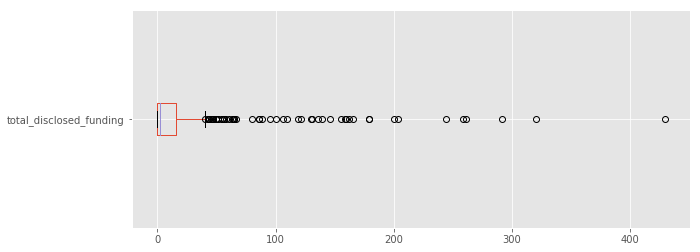

In [176]:
df_raw[(df_raw.country == 'India')]['total_disclosed_funding'].plot.box(vert=False, figsize=(10, 4))

#### The startups with disclosed funding more than 50 million may be considered as outliers. Let's inspect those closely.

In [177]:
# Let's check the startups which have received funding over 100 million
df_india_100_plus = df_raw[(df_raw.country == 'India') & (df_raw.total_disclosed_funding > 50)]

In [178]:
# Show the top 20 startups based on total_disclosed_funding
df_india_100_plus[['name', 'age', 'categories', 'round_of_funding', 'total_disclosed_funding', 'city']].sort_values(by='total_disclosed_funding', ascending=False)[0:20]

,name,age,categories,round_of_funding,total_disclosed_funding,city
319,Quikr,10,"Internet, Classifieds, Rental Property",10,429.076923,Mumbai
246,InMobi,11,"Marketing, Advertising, Mobile",6,320.600000,Bangalore
67,BigBasket,7,"E-Commerce, Shopping, Delivery Servi...",8,291.569231,Bangalore
231,hike,6,"Messaging, Apps, Mobile",5,261.000000,Delhi
43,Delhivery,7,"E-Commerce, Supply Chain Management,...",6,258.269231,Gurgaon
188,Zomato,10,"Reservations, Search Engine, Restaur...",9,243.800000,Gurgaon
212,BYJU'S,10,"Education, EdTech, Higher Education,...",7,204.000000,Bangalore
229,OYO,5,"Hotel, Hospitality, Leisure",5,200.000000,Gurgaon
289,FreeCharge,8,"Internet, Coupons, Payments",6,179.461538,Mumbai
101,Practo,10,"Health Care, SaaS, Marketplace",4,179.000000,Bangalore


- Most of these are well known names
- We are going to check the funding, age 

Text(0,0.5,'Number of Startups')

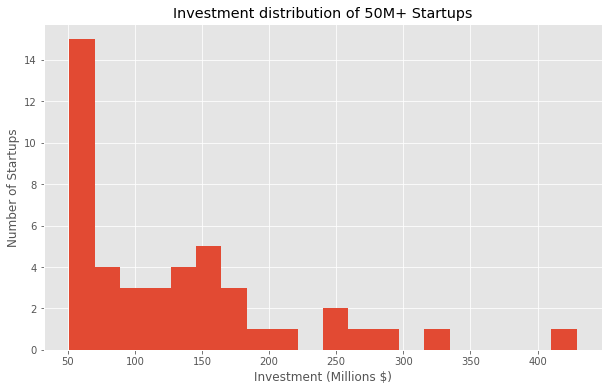

In [179]:
# Check the funding distribution
ax = df_india_100_plus.total_disclosed_funding.hist(bins=20, figsize=(10, 6))
ax.set_title("Investment distribution of 50M+ Startups")
ax.set_xlabel('Investment (Millions $)')
ax.set_ylabel('Number of Startups')

Text(0.5,0,'Investment (Millions $)')

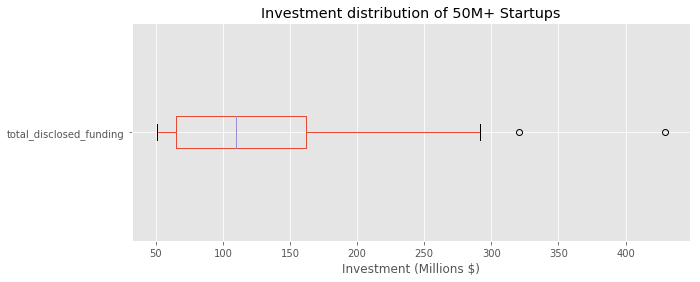

In [180]:
ax = df_india_100_plus.total_disclosed_funding.plot.box(vert=False, figsize=(10, 4))
ax.set_title("Investment distribution of 50M+ Startups")
ax.set_xlabel('Investment (Millions $)')

Text(0.5,0,'Age (Years)')

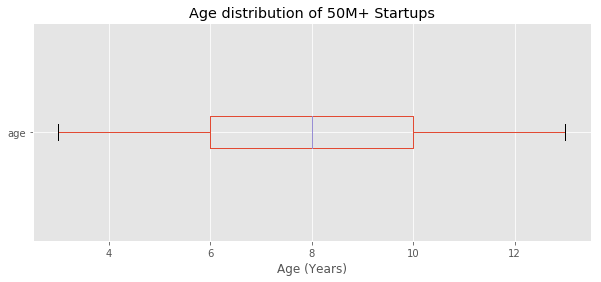

In [181]:
# Check the age distribution of these outliers
ax = df_india_100_plus.age.plot.box(vert=False, figsize=(10, 4), legend=False)
ax.set_title("Age distribution of 50M+ Startups")
ax.set_xlabel('Age (Years)')

In [182]:
df_india_100_plus.age.describe()

count    45.000000
mean      8.022222
std       2.750941
min       3.000000
25%       6.000000
50%       8.000000
75%      10.000000
max      13.000000
Name: age, dtype: float64

Text(0,0.5,'Investment (Million $)')

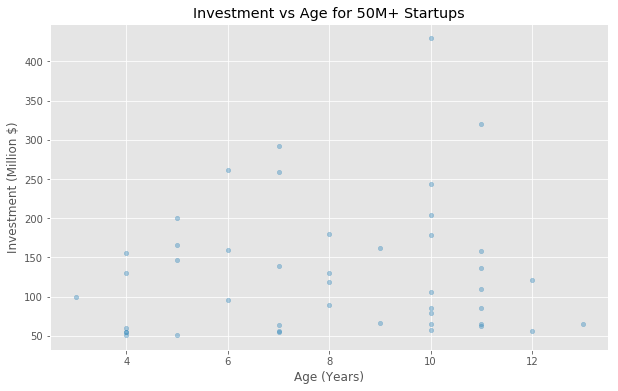

In [183]:
ax = df_india_100_plus.plot.scatter('age', 'total_disclosed_funding', figsize=(10, 6), legend=False, alpha=0.4)
ax.set_title("Investment vs Age for 50M+ Startups")
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Investment (Million $)')

- Observation
    - It takes time to become an outlier. Typical age of 50M+ startup is 8 years. It varies between 2 to 13.
    - There is no linear relationship between age and investment amount

#### What are the popular categories among these startups?

Text(0,0.5,'Categories')

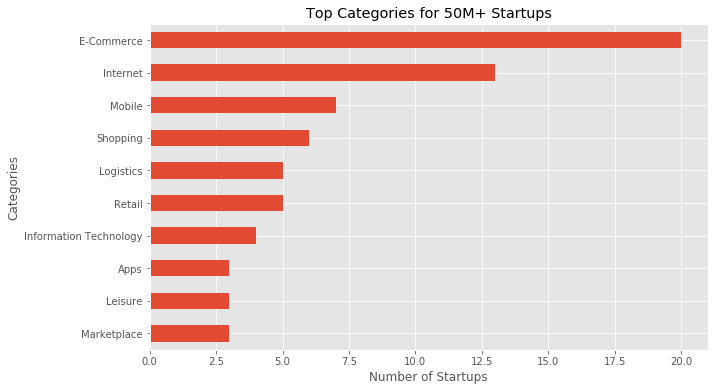

In [184]:
top_cat_100_plus = df_india_100_plus[list_of_categories].sum().sort_values(ascending=False)[0:10]
ax = top_cat_100_plus.sort_values().plot.barh(figsize=(10, 6))
ax.set_title("Top Categories for 50M+ Startups")
ax.set_xlabel('Number of Startups')
ax.set_ylabel('Categories')

Text(0,0.5,'City (India)')

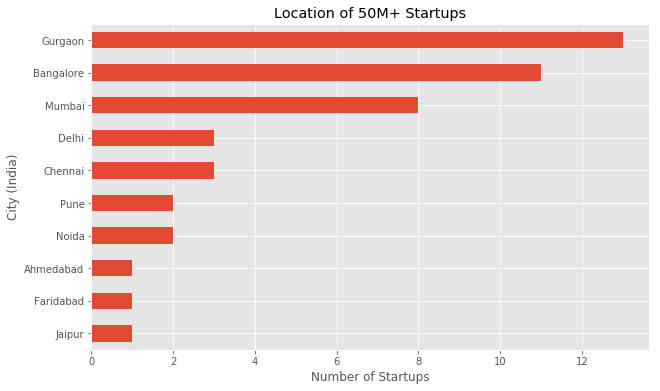

In [185]:
ax = df_india_100_plus.city.value_counts(ascending=True).plot.barh(figsize=(10, 6))
ax.set_title("Location of 50M+ Startups")
ax.set_xlabel('Number of Startups')
ax.set_ylabel('City (India)')